<h2>NOTE: This Jupyter Notebook is an assembled notebook that includes all members' work for a clear and neat presentation. Some models' constructions (via GridSearch) are extremely time-consuming. Therefore, some cells in this notebook are copied and pasted from all members' individual notebooks!<br></h2>

<h3> Team Name: Henry Erzi</h3>
<h3>Work Allocation:<br></h3>
Raymond Lu (z5277884): Multinomial Naive Bayes Model, Assembled Notebook<br>
Ziyang Liang (z5420778): Decision Tree Classifier Model, Ensemble Model Design<br>
Yangqi Zhang(z5235062): Support Vector Classification Model, Project Report<br>
Yunze Shi(z5244619): Logistic Regression Model, Project Report<br>
Yinong Wang(z5219512): Neural Network Research, Ensemble Model Design <br>


In [17]:
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import altair as alt
# need to 'pip install vega' before using renderer
alt.renderers.enable("notebook")
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing,metrics
from sklearn.metrics import accuracy_score,f1_score,recall_score,roc_auc_score
from sklearn.model_selection import cross_val_score # get a specific score of a model using CV
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve,StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.utils import shuffle
from sklearn.exceptions import ConvergenceWarning
import scipy
import os
from joblib import dump, load
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as prfs
# test for Selecting The Best Number Of Components For TSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from varname import varname
from collections import Counter
%matplotlib inline
#fix random seed
np.random.seed(1)

In [3]:
!jupyter nbextension enable vega --py --sys-prefix

# 1. Individual Model Construction

## 1.1 Data Analysis

### 1.1.1 Data Import

In [18]:
TRAINING_FILE = "../training.csv"
df_train = pd.read_csv(TRAINING_FILE)
print(df_train.isnull().sum())
df_train.head(5)

article_number    0
article_words     0
topic             0
dtype: int64


article_number                                      article_words  \
0               1  open,absent,cent,cent,cent,stock,inflow,rate,k...   
1               2  morn,stead,end,end,day,day,day,patch,patch,pat...   
2               3  socc,socc,world,world,recent,law,fifa,fifa,fif...   
3               4  open,forint,forint,forint,forint,cent,cent,ste...   
4               5  morn,complet,weekend,minut,minut,minut,arrow,d...   

           topic  
0  FOREX MARKETS  
1  MONEY MARKETS  
2         SPORTS  
3  FOREX MARKETS  
4     IRRELEVANT

From the result above, it could be seen that there are no *null* values in the training data set. And the topic feature is supposed to be predicted by article_words feature.

### 1.1.2 Plot Data Distribution

In [5]:
data_x = df_train.article_words
data_y = df_train.topic

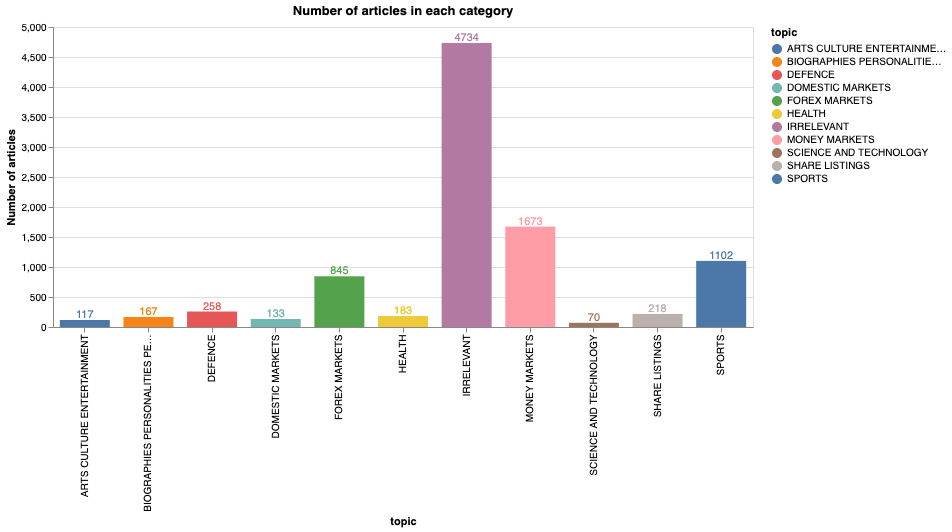

In [244]:
alt.data_transformers.disable_max_rows()
bars = alt.Chart(data_y.to_frame()).mark_bar(size=50).encode(
x=alt.X("topic"),
y=alt.Y("count():Q", axis=alt.Axis(title='Number of articles')),
tooltip=[alt.Tooltip('count()', title='Number of articles'), 'topic'],
color='topic'

)

text = bars.mark_text(
align='center',
baseline='bottom',
).encode(
text='count()'
)

(bars + text).properties(
    height=300, 
    width=700,
    title = "Number of articles in each category",
)

From the plot above, it could be seen that the data distribution in the training data set is severely imbalanced, with **IRRELEVANT** topic occupies more than half amount.

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 11 Text major ticklabel objects>)

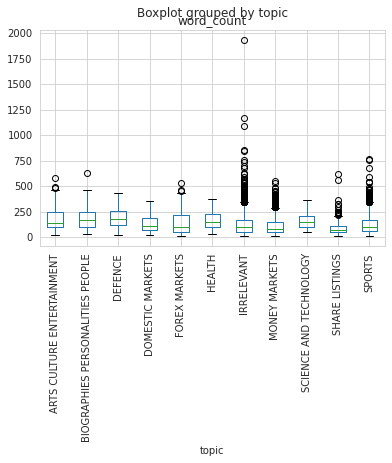

In [6]:
data = df_train
data['word_count'] = data.article_words.str.count(",")+1
data.boxplot(column ='word_count',by ='topic')
plt.xticks(rotation=90)

From the boxplot above, it could be seen that the variance of word count in the **IRRELEVANT** topic is far higher than other topics. This means that the word count of **IRRELEVANT** topic varies in a substantial range.

### 1.1.3 Key Word Analysis for Each Topic

In [10]:
# count the occurences of each word in the given data
def word_count_function(word_list,topic_df):
    #return the only the words in word_list occur in the topic_df
    occurence_df = pd.DataFrame() #show their occurence in other topics 
    for words in word_list:
        occurence_dict = {}
        for name, group in topic_df :
            word_counter = Counter(" ".join(group["article_words"]).split(","))
            occurence = word_counter[words]
            avg_occurence = occurence / len(group)
            occurence_dict.update({name:avg_occurence})
        occur_series = pd.Series(occurence_dict) 
        occur_series.name = words
        occurence_df = occurence_df.append(occur_series, ignore_index = True)
    return(occurence_df.T)

In [14]:
#finding the most frequent words in training set by topics
topic_group = df_train.groupby('topic')
most_frequent_word_list = {}
word_list_10 = []
for name, group in topic_group :
    frequent_words = Counter(" ".join(group["article_words"]).split(",")).most_common(10)
    most_frequent_word_list.update({name:frequent_words})
    common_words = [i[0] for i in frequent_words]
    word_list_10 = word_list_10 + common_words
print(most_frequent_word_list)

{'ARTS CULTURE ENTERTAINMENT': [('year', 156), ('film', 153), ('million', 102), ('stat', 83), ('work', 81), ('offic', 80), ('show', 72), ('releas', 72), ('peopl', 70), ('music', 69)], 'BIOGRAPHIES PERSONALITIES PEOPLE': [('year', 249), ('presid', 198), ('yeltsin', 140), ('stat', 133), ('hospit', 124), ('offic', 122), ('lead', 121), ('minist', 119), ('told', 117), ('report', 113)], 'DEFENCE': [('nato', 511), ('stat', 410), ('milit', 406), ('forc', 381), ('defend', 357), ('minist', 345), ('offic', 317), ('russia', 299), ('presid', 238), ('plan', 235)], 'DOMESTIC MARKETS': [('import', 541), ('ton', 324), ('percent', 265), ('year', 262), ('oil', 191), ('trad', 189), ('chin', 186), ('export', 161), ('million', 151), ('produc', 140)], 'FOREX MARKETS': [('dollar', 3358), ('bank', 2178), ('rate', 1720), ('trad', 1671), ('market', 1662), ('percent', 1336), ('currenc', 1214), ('deal', 1208), ('mark', 1191), ('yen', 962)], 'HEALTH': [('year', 253), ('health', 245), ('stat', 241), ('diseas', 184),

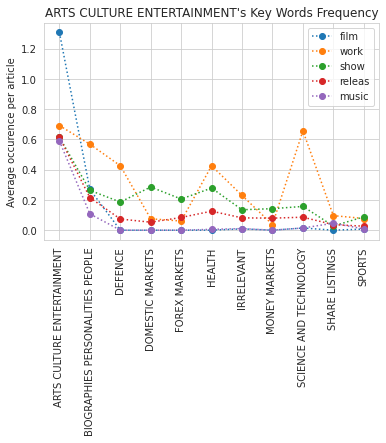

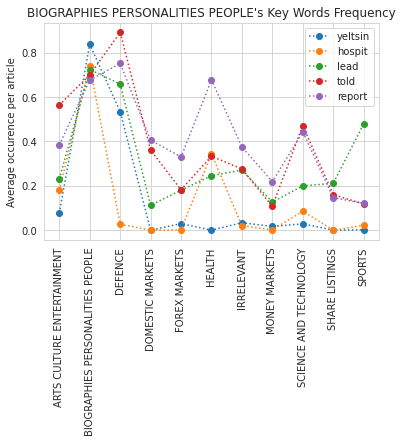

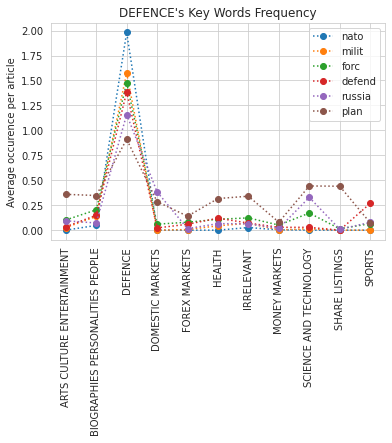

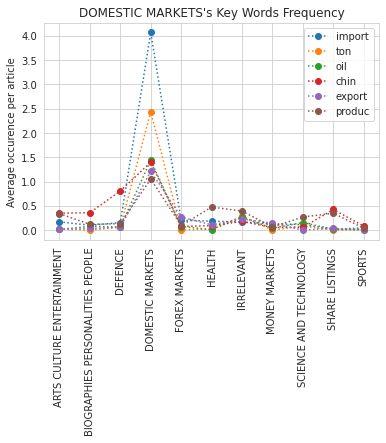

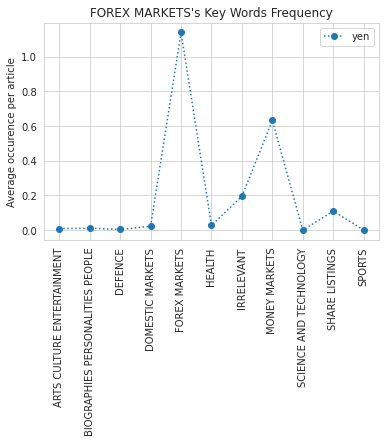

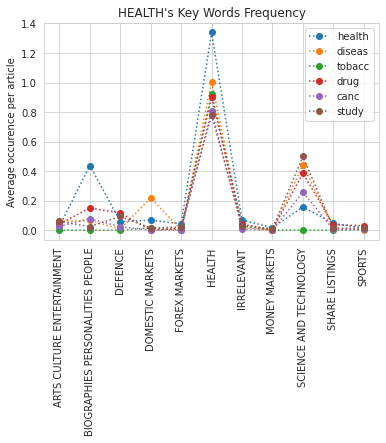

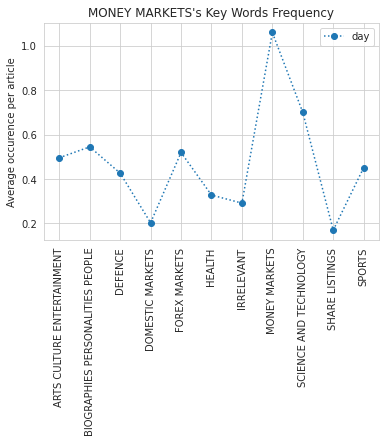

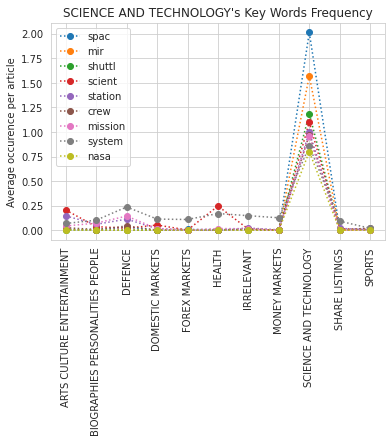

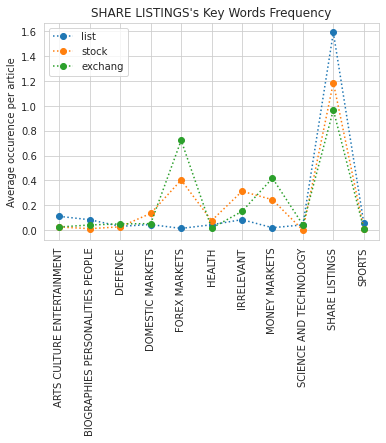

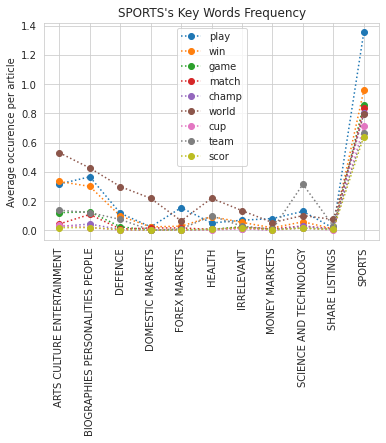

In [15]:
word_list_group = [ [i for i in word_list_10[j*10 :(j+1)*10 ] if word_list_10.count(i) == 1] for j in range(11) ]
#visaulize key word's performance
for i in range(11):
    if i == 6:
        continue #irrelevant do not have any words
    my_words = word_list_group[i]
    my_df = word_count_function(my_words,topic_group)
    
    my_df.columns = my_words
    my_df.plot(marker='o',style = ':')
    plt.xticks(np.arange(11), list(my_df.index),rotation=90)

    plt.title(list(my_df.index)[i] + '\'s Key Words Frequency')
    plt.ylabel('Average occurence per article')
    plt.show()

The plots above shows for each topic, how is the distribution of its own top key words among all topics other than **IRRELEVANT**. It could be seen that for **BIOGRAPHIES PERSONALITIES PEOPLE**, its top key words' occurences are not distinguishing from the ones of other topics. Worse still, its two key words, *told* and *report* have higer occurence in other topics. This indicates that, the prediction of **BIOGRAPHIES PERSONALITIES PEOPLE** would be in poor quality since this topic's features are not characteristical. <br><br>
In contrast, **DEFENCE**, **SHARE LISTING** and **SPORTS** are supposed to have ideal predictions on account that all their corresponding key words' occurences are obviously lower among other topics.

## 1.2 Solve Data Imbalance

In order to generate precise models, the data imbalance needs to be solved. Otherwise, the generated models are more likely to predict the results to be the majority topic in the training set. For the purpose of eliminating such bias, SMOTE (Synthetic Minority Oversampling Technique) is introduced to solve this problem.

*SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.*<br>
<div style="text-align:right">— Page 47, Imbalanced Learning: Foundations, Algorithms, and Applications, 2013.</div>

In [5]:
new_df = df
train_x = new_df.article_words.apply(lambda x: x.replace('_', ''))
train_y = new_df.topic
le = preprocessing.LabelEncoder()
le.fit(train_y)
encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
en_train_y = le.transform(train_y)
topics = list(set(df['topic']))
TOPIC_COUNT = len(topics)
smote = SMOTE(random_state=1)
vectorizer = TfidfVectorizer()
vectorizer.fit(train_x)
train_vectors = vectorizer.transform(train_x)
smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)
print(smo_x.shape)
print(smo_x.nnz/float(smo_x.shape[0]))

(52074, 35817)
160.3542266774206


From the output it could be seen that, after applying SMOTE, the extracted Tfidf Vectors are sparse, with merely 160 eigenvalues over 35817 dimensions

## 1.3 Key Word Extraction

We assume that extracting key words from the article_words feature in data could improve the model's prediction, considering that some words in the test set could be low-frequent or even not showing up in the training set, which might bring noises to the model prediction.

The strategy can be described as follows. 
1. Key_word_selection(D, n)
2. For each topic S in Dataset D:
<ol>
    <li> Combine all the words for all the articles in topic S</li>
    <li>Count the occurence of each words </li>
    <li>Sort the counts and keep the most frequent n words</li>
</ol>
3. Create a list of keywords in all topics L
4. Iterate through all the articles and only keep words in the list L, discard all other words. 


In [19]:
from collections import Counter
import pandas as pd

def word_list_generator(data_group, n=10):
    my_word_list= []
    for name, group in data_group :
        frequent_words = Counter(" ".join(group["article_words"]).split(",")).most_common(n)
        #most_frequent_word_list.update({name:frequent_words})
        common_words = [i[0] for i in frequent_words]
        my_word_list = my_word_list + common_words
    return(my_word_list)

def keep_key_words(x,word_list):
    key_list = [i for i in x.split(",") if i in  word_list]
    key_str = str(key_list).replace("'","").replace(" ","").replace("[","").replace("]","")
    return(key_str)

def df_keyword_generator(df_test, df_keywords):
    '''generate key words features in df_test based on keywords in df_keywords by topic '''
    topic_group = df_keywords.groupby('topic')
    words_in_df = df_test.article_words
    
    word_list10 = word_list_generator(topic_group, n=10)
    key_word_10 = words_in_df.apply(keep_key_words, args=(word_list10,))
    df_test['key_word_10'] = key_word_10
    
    word_list20 = word_list_generator(topic_group, n=20)
    key_word_20 = words_in_df.apply(keep_key_words, args=(word_list20,))
    df_test['key_word_20'] = key_word_20
    
    word_list50 = word_list_generator(topic_group, n=50)
    key_word_50 = words_in_df.apply(keep_key_words, args=(word_list50,))
    df_test['key_word_50'] = key_word_50
    
    word_list100 = word_list_generator(topic_group, n=100)
    key_word_100 = words_in_df.apply(keep_key_words, args=(word_list100,))
    df_test['key_word_100'] = key_word_100
    return(df_test)

df_train = df_keyword_generator(df_train,df_train)

In [20]:
df_train

article_number                                      article_words  \
0                  1  open,absent,cent,cent,cent,stock,inflow,rate,k...   
1                  2  morn,stead,end,end,day,day,day,patch,patch,pat...   
2                  3  socc,socc,world,world,recent,law,fifa,fifa,fif...   
3                  4  open,forint,forint,forint,forint,cent,cent,ste...   
4                  5  morn,complet,weekend,minut,minut,minut,arrow,d...   
...              ...                                                ...   
9495            9496  cloud,provid,hope,centur,erupt,rule,recent,sou...   
9496            9497  stock,stock,stock,declin,access,week,worry,blo...   
9497            9498  rate,million,million,belarus,dollar,dollar,nov...   
9498            9499  flow,bullet,bullet,bullet,bullet,bullet,bullet...   
9499            9500  helsingin,mechan,follow,sanomat,limit,market,r...   

              topic                                        key_word_10  \
0     FOREX MARKETS  stock,rate,defend,bank,bank,bank,bank,bank,dol...   
1     MONEY MARKETS  day,day,day,bank,year,dollar,dollar,deal,deal,...   
2            SPORTS  world,world,stat,stat,stat,stat,year,releas,re...   
3     FOREX MARKETS  play,bank,bank,mark,mark,percent,percent,perce...   
4        IRRELEVANT                                                day   
...             ...                                                ...   
9495        DEFENCE  scient,year,year,lead,plan,plan,day,peopl,peop...   
9496     IRRELEVANT  stock,stock,stock,play,year,year,dollar,dollar...   
9497  FOREX MARKETS  rate,million,million,dollar,dollar,trad,exchan...   
9498     IRRELEVANT           day,year,year,year,report,show,show,show   
9499  FOREX MARKETS  market,rate,year,year,currenc,currenc,currenc,...   

                                            key_word_20  \
0     cent,cent,cent,stock,rate,end,won,won,won,won,...   
1     end,end,day,day,day,point,time,bank,year,dolla...   
2     world,world,stat,stat,stat,stat,govern,time,ye...   
3     cent,cent,end,play,unit,bank,bank,mark,mark,pe...   
4                                  day,time,season,clos   
...                                                 ...   
9495  scient,year,year,month,lead,expect,expect,high...   
9496  stock,stock,stock,week,play,point,govern,inves...   
9497  rate,million,million,dollar,dollar,trad,newsro...   
9498  week,week,end,day,arm,polic,polic,year,year,ye...   
9499  market,econom,econom,econom,econom,econom,econ...   

                                            key_word_50  \
0     open,cent,cent,cent,stock,rate,end,won,won,won...   
1     end,end,day,day,day,point,time,bank,early,year...   
2     socc,socc,world,world,stat,stat,stat,stat,gove...   
3     open,cent,cent,end,play,unit,made,bank,bank,tu...   
4     minut,minut,minut,day,friday,friday,race,time,...   
...                                                 ...   
9495  south,scient,capit,intern,year,year,set,set,se...   
9496  stock,stock,stock,week,play,friday,point,gover...   
9497  rate,million,million,dollar,dollar,trad,newsro...   
9498  week,week,end,day,arm,man,die,polic,polic,year...   
9499  market,econom,econom,econom,econom,econom,econ...   

                                           key_word_100  
0     open,cent,cent,cent,stock,rate,end,won,won,won...  
1     end,end,day,day,day,index,point,time,busi,bank...  
2     socc,socc,world,world,recent,law,stat,stat,sta...  
3     open,cent,cent,end,play,unit,made,bank,bank,ra...  
4     minut,minut,minut,day,friday,friday,race,time,...  
...                                                 ...  
9495  centur,rule,recent,south,local,scient,capit,ju...  
9496  stock,stock,stock,week,play,friday,index,point...  
9497  rate,million,million,dollar,dollar,trad,interb...  
9498  hit,hit,hit,week,week,end,day,arm,man,die,poli...  
9499  market,econom,econom,econom,econom,econom,econ...  

[9500 rows x 7 columns]

## 1.4 Vectorizers

Considering that the given data set has already gone through the word pre-processing, and how the word data given is in the format of **Bag of Words**. In order to train models with bags of words, we need to transform the words to numerical vectors first.

### 1.4.1 Count Vectorizer

Ignore shape of texts, focus on individual words (sometimes multiple words back to back)

- Tokenization
- Vocabulary building
    - **all** words that appear in **all** of the documents in the corpus, and number them (say, in alphabetic order)
- Encodeing
    - for each **document**, count how often each word in the vocabulary appear in this document:
        - 0 if not present
    
See the example below: adoped from the same chapter of the book
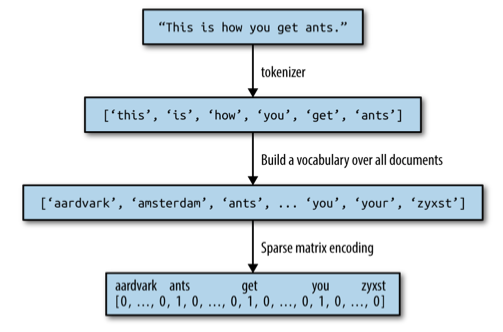

<div align="center">
    Process of BoW
</div>

The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.

You can use it as follows:

    1.Create an instance of the CountVectorizer class.
    2.Call the fit() function in order to learn a vocabulary from one or more documents.
    3.Call the transform() function on one or more documents as needed to encode each as a vector.

An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document.<br>
<div style="text-align:right">— Jason Brownlee, How to Prepare Text Data for Machine Learning with scikit-learn, 2017.</div>

### 1.4.2 Tfidf Vectorizer

Tf-idf is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

- tf: term frequency in one document

- idf: inverse document frequency

In a **document**, the most frequent words tend to be more descripative of the document.

**But** words like "a", "the", "what" appear everywhere in all kinds of documents, they are not good keywords to distinguish documents.

Instead we are more interested in words that appear only in this specific document we are studying.

$$TFIDF(w,d) = tf\cdot log(\frac{N_d+1}{N_{d|w} + 1}) + 1$$
$N_d$: the number of documents in the training set

$N_{d|w}$: the number of documents in the training set that contains the word $w$

tf-idf is usually l2-normalized, i.e. the norm of the feature vector transformed from a document is 1.

Term Frequency (TF)

The number of times a word appears in a document divded by the total number of words in the document. Every document has its own term frequency.
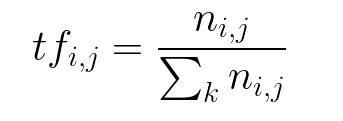

Inverse Data Frequency (IDF)

The log of the number of documents divided by the number of documents that contain the word w. Inverse data frequency determines the weight of rare words across all documents in the corpus.
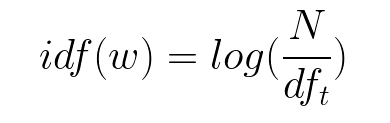<br>
<div style="text-align:right">— Cory Maklin, TF IDF | TFIDF Python Example, 2019.</div>

## 1.5 Grid Search & Cross Validation

In GridSearchCV, the training set is further splited into (k-1) <font color='red'>**training**</font> and 1 <font color='green'>**validating**</font> folds, where the <font color='green'>**validating**</font> set is supposed to simulate the <font color='blue'>**test**</font> set (unseen data).

Often, our fisrt step is to perform normalization (aka rescaling, e.g min_max) to the whole `X_train`.

Meaning that we have collected statistical infomation from the <font color='green'>**validating**</font> set before using it to validate our model.

This is clearly not the case for test set, we do not know anything (e.g. min, max) about the test set when learning a model, in other words, the <font color='green'>**validating**</font> set splitted from training set **after** such normalization fails to simulate completely unseen data:
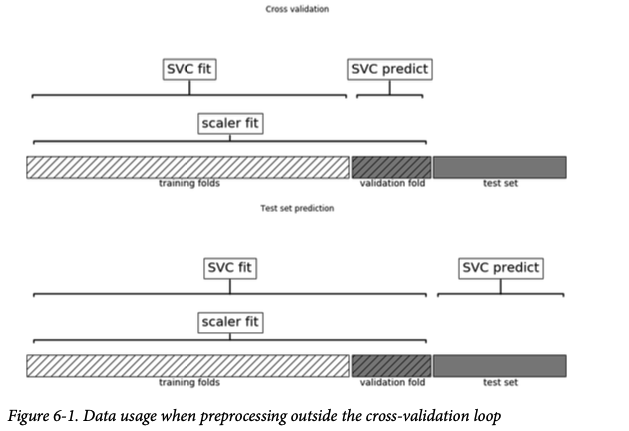

Idealy, each split in cross validation should apply normalization to the (k-1) <font color='red'>**training**</font> folds respectively, but leave out the 1 <font color='green'>**validating**</font> fold while doing so:
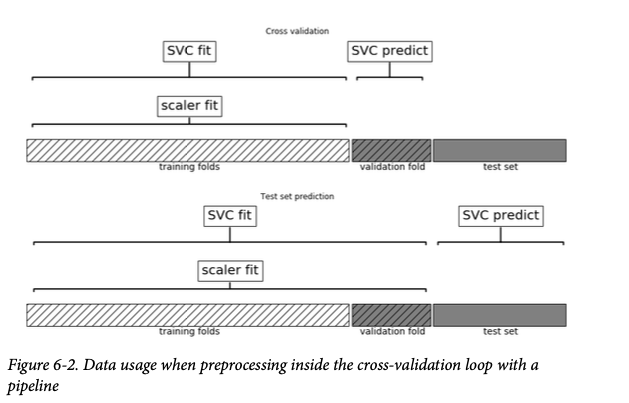

## 1.6 Functions Used In Models Construction

The following functions are functions that shared in different model constructions.

In [21]:
# Get scores for a particular model
def get_scores(en_train_y,pred_y,model_name,topic=None):
    f1 = f1_score(en_train_y,pred_y,average='macro')
    accuracy = accuracy_score(en_train_y,pred_y)
    recall = recall_score(en_train_y,pred_y,average='macro')
    if(topic==None):
        print("F1 score for ",model_name," model is ",f1)
        print("Accuracy score for ",model_name," model is ",accuracy)
        print("Recall score for ",model_name," model is ",recall,"\n")
    else:
        return ([topic,{'accuracy':accuracy,'f1':f1,'recall':recall}])
    
def save_variable(variable,filename):
    file_name = "Models/"+filename+".joblib"
    if not os.path.exists(file_name):
        with open(file_name, "wb") as file:
            dump(variable, file, compress=True)
    else:
        print("Warn: this model already exits...")
        
def retrieve_variable(filename):
    file_name = "Models/"+filename+".joblib"
    return(load(file_name))

# Show each topic's f1, accuracy and recall scores
def scores_for_topics(df,topics,model,le):
    scores = []
    for topic in topics:
        topic_scores(df,topic,model,le,scores)
    scores.sort(reverse=True,key=lambda x:x[1]['accuracy'])
    for item in scores:
        print(item)
        
def namestr(obj):
    return [name for name in globals() if globals()[name] is obj][0]

# For an individual topic, get its f1, accuracy and recall scores        
def topic_scores(df,topic,model,le,scores):
    filtered_df = df[df.topic==topic]
    test_x = filtered_df.key_word.apply(lambda x: x.replace('_', ''))
    test_y = filtered_df.topic
    #le.fit(train_y)
    en_test_y = le.transform(test_y)
    prediction = model.predict(test_x)
    scores.append(get_scores(en_test_y,prediction,type(model).__name__,topic))
    
# SMOTE the training data with vectorizer
def smote_data(df_train,vectorizer,col_x):
    # get train_x and train_y
    new_df = df_train
    new_df = new_df.dropna()
    train_x = new_df[col_x].apply(lambda x: x.replace('_', ''))
    train_y = new_df.topic
    le = preprocessing.LabelEncoder()
    le.fit(train_y)
    encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
    en_train_y = le.transform(train_y)
    topics = list(set(new_df['topic']))
    # Using SMOTE to solve imbalance
    smote = SMOTE(random_state=1)
    vectorizer.fit(train_x)
    train_vectors = vectorizer.transform(train_x)
    smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)
    new_train_x = vectorizer.inverse_transform(smo_x)
    new_train_x = pd.Series([','.join(item) for item in new_train_x])
    return(new_train_x,smo_y,topics,le,encode_mapping)

# test the model's accuracy with dataframe named df_test      
def test_model(df_test,model,le,encode_mapping):
    test_x = df_test.key_word
    test_y = df_test.topic
    topics = list(set(df_test['topic']))
    en_test_y = le.transform(test_y)
    y_pred = model.predict(test_x)
    get_scores(en_test_y,y_pred,type(model).__name__)
    print(encode_mapping)
    print(f"Classification Report:\n{classification_report(en_test_y, y_pred)}")
    print("The scores for each topic is:")
    scores_for_topics(df_test,topics,model,le)
    conf_matrix = confusion_matrix(en_test_y, y_pred)
    print(conf_matrix)
    fig1 = plt.figure(figsize=(13,6))
    sns.heatmap(conf_matrix,
    #             square=True,
                annot=True, # show numbers in each cell
                fmt='d', # set number format to integer in each cell
                yticklabels=le.classes_,
                xticklabels=model.classes_,
                cmap="Blues",
    #             linecolor="k",
                linewidths=.1,
               )
    plt.title(
              f"Confusion Matrix on Test Set | " 
              f"Classifier: {'+'.join([step for step in model.named_steps.keys()])}", 
              fontsize=14)
    plt.xlabel("Actual: False positives for y != x", fontsize=12)
    plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
    plt.show()

## 1.7 Multinomial Naive Bayes Model

When Bayes' Rule is applied to documents and classes, we have:<br>
&emsp; (1)For a document *d* and a class *c* <br>
&emsp; $P(c|d)= \frac{P(d|c)P(c)}{P(d)}$ <br>
&emsp; $C_{MAP}=\underset{c\in C}{\operatorname{argmax}}P(x_{1},x_{2},...,x{n}|c)P(c)$ (MAP is "maximum a posterior" = most likely class)<br>
&emsp; $C_{NB}=\underset{c\in C}{\operatorname{argmax}}P(c_{j})\prod_{x \in X}P(X|c)$<br>
&emsp; (2)Maximum Likelihood Estimates <br>
&emsp;  $\hat{P}(c_{j})=\frac{doccount(C=c_{j})}{N_{doc}}$<br>
&emsp; $\hat{P}(w_{i}|c_{j})=\frac{count(w_{i},c_{j})}{\sum_{w \in V}count(w,c_{j})}$ &emsp;(fractions of times word $w_{i}$ appears among all words in documents of topic $c_{j}$).<br>
&emsp; (3)Laplace (add-1) Smoothing for Naive Bayes <br>
&emsp; $\hat{P}(w_{i}|c)=\frac{count(w_{i},c)+1}{\sum_{w \in V}(count(w,c))+1}=\frac{count(w_{i},c)+1}{\sum_{w \in V}count(w,c) + |V|}$

### Functions Used In Multinomial Naive Bayes

In [4]:
# get a model that the training data is SMOTEd with vectorizer
def get_model(df_train,vectorizer,col_x):
    new_train_x,smo_y,topics,le,encode_mapping = smote_data(df_train,vectorizer,col_x)
    # Start grid search
    count_clf_NB,count_clf_accuracy = grid_search(CountVectorizer(),MultinomialNB(),\
                                                  new_train_x,smo_y,topics)
    tfidf_clf_NB,tfidf_clf_accuracy = grid_search(TfidfVectorizer(norm=None),MultinomialNB(),\
                                                  new_train_x,smo_y,topics)
    if(count_clf_accuracy>=tfidf_clf_accuracy):
        print(f'*************************************************************')
        print(f'Now the training set is {df_train.name}, and the model chosen is count_clf_NB')
        print(f'The accuracy is {count_clf_accuracy}')
        return (count_clf_NB,le,encode_mapping)
    else:
        print(f'*************************************************************')
        print(f'Now the training set is {df_train.name}, and the model chosen is tfidf_clf_NB')
        print(f'The accuracy is {tfidf_clf_accuracy}')
        return (tfidf_clf_NB,le,encode_mapping)
    
# Combine pipeline and GridSearchCV together
# Since grid search is time-consuming, the range of each elements in the parameter grid is 
# comparatively small
def grid_search(vectorizer,model,train_x,train_y,topics):
    kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
    estimators = [
                ("vectorizer",vectorizer),
                ("model",model)
                  ]
    pipe = Pipeline(estimators)

    param_grid = {
                "vectorizer__min_df":[i for i in range(1,6)],
                "model__alpha":[0.001,0.01,0.1,1],
                "model__class_prior":[None,[1/len(topics) for i in range(len(topics))]],
                "model__fit_prior":[True,False]
                 }
    grid_search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=-1)
    grid_result=grid_search.fit(train_x, train_y)
    return (grid_result.best_estimator_,grid_result.best_score_)

### 1.7.1 Pipeline Hyper Parameter

The description of hyper parameter tuning is given below.<br>
- min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.<br>
- alpha: Additive smoothing parameter.
- class_prior: Prior probabilities of the classes. Because we assume the topic classes are in uniform distribution, we set the prior probabilities identical for all topics.
- fit_prior: Whether to learn class prior probabilities or not.

Since GridSearchCV() function can find out the optimal hyper parameters for users, we do not care what exactly the optimal hyper parameters are, but just retrieve the optimal encapsulated model.

### Two Layer Model Construction

We construct a two layer model. The first layer is predicting the target article belongs to **IRRELEVANT** topic or not. If the prediction is not **IRRELEVANT**, the target article goes to the second layer and gets predicted that in the rest of topics, which it belongs to. Considering a target article could be mistakenly predicted as not **IRRELEVANT** in the first layer, the second layer model should be still able to predict an article in **IRRELEVANT** topic. 

**THE ABOVE IDEA IS THE SAME IN PART 1.8,1.9, AND 1.10.**

### 1.7.2 First Layer Construction

In [9]:
new_df = df_train
rel_topic = [] # relevance topic
for i in range(new_df.shape[0]):
    if(new_df.topic.iloc[i]=="IRRELEVANT"):
        rel_topic.append("IRRELEVANT")
    else:
        rel_topic.append("RELEVANT")
new_df['rel_topic']=rel_topic
rel_df_train= pd.DataFrame(df_train,columns=['article_words','rel_topic']).rename(columns={'rel_topic':'topic'})
rel_df_train.name = 'rel_df_train'

In [10]:
%%time
# training data is SMOTED with TfidfVectorizer
rel_clf_tfidf_NB,_,_= get_model(rel_df_train,TfidfVectorizer(),'article_words')

*************************************************************
Now the training set is rel_df_train, and the model chosen is count_clf_NB
The accuracy is 0.8369710788616329
CPU times: user 12.8 s, sys: 7.42 s, total: 20.2 s
Wall time: 6min 30s


In [21]:
%%time
# training data is SMOTED with CountVectorizer
rel_clf_count_NB,_,_= get_model(rel_df_train,CountVectorizer(),'article_words')

*************************************************************
Now the training set is rel_df_train, and the model chosen is count_clf_NB
The accuracy is 0.8360271326782245
CPU times: user 17.3 s, sys: 12.7 s, total: 30 s
Wall time: 8min 30s


Therefore, we choose the model whose training data is SMOTED with TfidfVectorier here.

In [22]:
save_variable(rel_clf_tfidf_NB,"rel_clf_tfidf_NB")

### 1.7.3 Secod Layer Construction

When we train the model with training data, we want the model is trained with as much data as possible for guaranteeing the prediction accuracy. Therefore, we only train the model with full data and top 100 key words data.

#### 1.7.3.1 SMOTE With TfidfVectorizer

In [14]:
new_train_x,smo_y,topics,le,encode_mapping = smote_data(df_train,TfidfVectorizer(),'article_words')
new_train_x_100,_,_,_,_ = smote_data(df_train,TfidfVectorizer(),'key_word_100')

In [15]:
train_x,valid_x,train_y,valid_y = train_test_split(new_train_x,smo_y,test_size=0.3,random_state=42)
valid_size = valid_x.shape[0]
train_x_100,valid_x_100,train_y,valid_y = train_test_split(new_train_x_100,smo_y,test_size=0.3,random_state=42)

##### First we build the model with train_x first.

In [12]:
%%time
# Start grid search
count_clf_NB,count_clf_accuracy = grid_search(CountVectorizer(),MultinomialNB(),\
                                              train_x,train_y,topics)
tfidf_clf_NB,tfidf_clf_accuracy = grid_search(TfidfVectorizer(norm=None),MultinomialNB(),\
                                              train_x,train_y,topics)

CPU times: user 1min 17s, sys: 1min 10s, total: 2min 27s
Wall time: 1h 4min


In [13]:
clf_NB = None
if(count_clf_accuracy>=tfidf_clf_accuracy):
    print('count chosen')
    clf_NB = count_clf_NB
else:
    print('tfidf chosen')
    clf_NB = tfidf_clf_NB

tfidf chosen


In [15]:
# reverse valid_y
rev_valid_y = le.inverse_transform(valid_y)

----------------------------------------------------------------------
Now,the test_df is valid_x_10
F1 score for  Pipeline  model is  0.6060058186436652
Accuracy score for  Pipeline  model is  0.6394478844169247
Recall score for  Pipeline  model is  0.642822930876334 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.48      0.60      1381
           1       0.75      0.30      0.43      1408
           2       0.73      0.85      0.78      1414
           3       0.62      0.97      0.76      1346
           4       0.57      0.30      0.39      1411
           5       0.65      0.77      0.70      1432
           6       0.17      0.05      0.08      1480
           7       0.46      

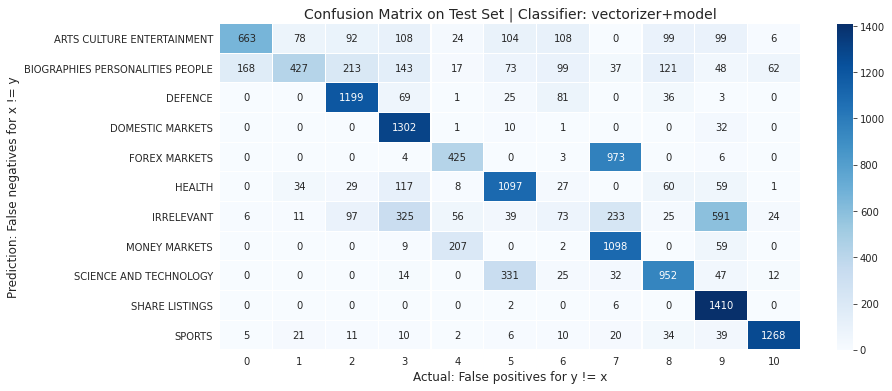

----------------------------------------------------------------------
Now,the test_df is valid_x_20
F1 score for  Pipeline  model is  0.6690282734882739
Accuracy score for  Pipeline  model is  0.6926599587203303
Recall score for  Pipeline  model is  0.6960156377166793 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.51      0.64      1381
           1       0.72      0.50      0.59      1408
           2       0.79      0.91      0.84      1414
           3       0.75      0.99      0.86      1346
           4       0.64      0.32      0.42      1411
           5       0.70      0.88      0.78      1432
           6       0.18      0.08      0.11      1480
           7       0.46     

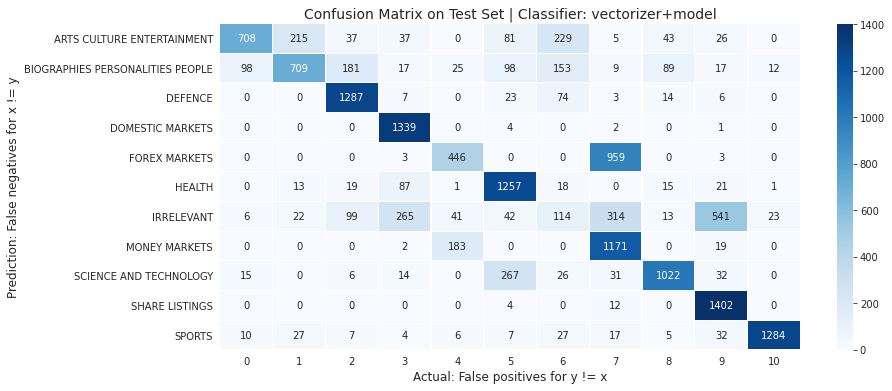

----------------------------------------------------------------------
Now,the test_df is valid_x_50
F1 score for  Pipeline  model is  0.7090315321806421
Accuracy score for  Pipeline  model is  0.7297471620227038
Recall score for  Pipeline  model is  0.7330162220650392 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.61      0.74      1381
           1       0.79      0.58      0.67      1408
           2       0.73      0.94      0.82      1414
           3       0.83      0.99      0.90      1346
           4       0.65      0.30      0.41      1411
           5       0.79      0.94      0.86      1432
           6       0.26      0.12      0.16      1480
           7       0.47     

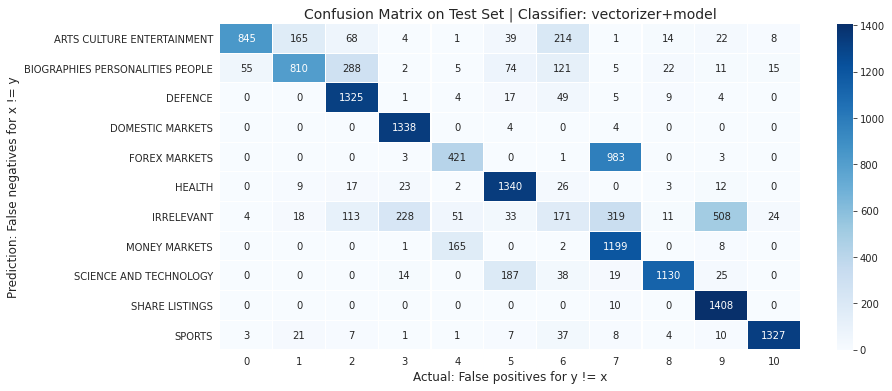

----------------------------------------------------------------------
Now,the test_df is valid_x_100
F1 score for  Pipeline  model is  0.768182732198574
Accuracy score for  Pipeline  model is  0.7816692466460269
Recall score for  Pipeline  model is  0.7847917024466192 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86      1381
           1       0.85      0.74      0.79      1408
           2       0.81      0.93      0.86      1414
           3       0.87      1.00      0.93      1346
           4       0.69      0.34      0.45      1411
           5       0.85      0.94      0.89      1432
           6       0.45      0.22      0.30      1480
           7       0.49     

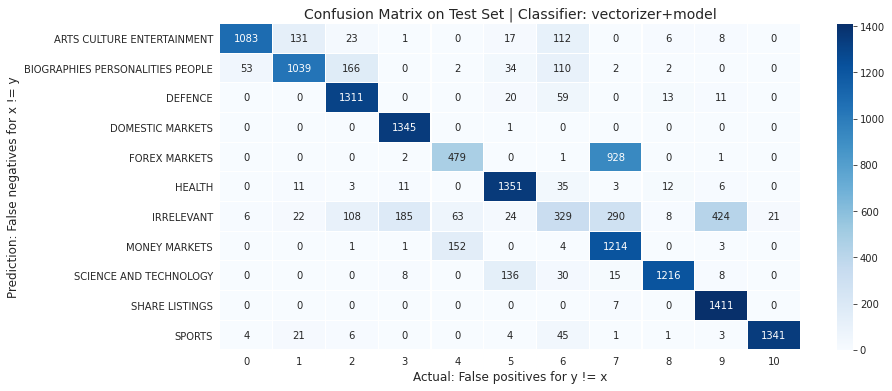

----------------------------------------------------------------------
Now,the test_df is valid_x
F1 score for  Pipeline  model is  0.9614464063257244
Accuracy score for  Pipeline  model is  0.9612358101135191
Recall score for  Pipeline  model is  0.9618060278223646 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1381
           1       0.99      1.00      1.00      1408
           2       0.99      1.00      1.00      1414
           3       0.99      1.00      1.00      1346
           4       0.90      0.81      0.85      1411
           5       1.00      1.00      1.00      1432
           6       0.99      0.84      0.91      1480
           7       0.77      0.

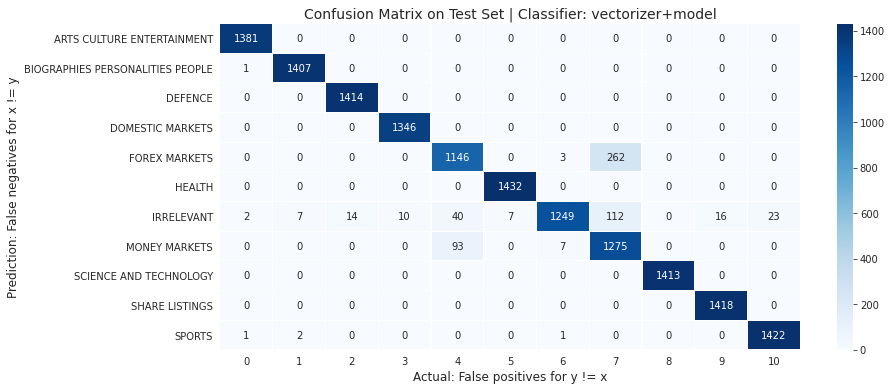

In [16]:
valid_set =[valid_x_10,valid_x_20,valid_x_50,valid_x_100,valid_x]
for ele in valid_set:
    print('----------------------------------------------------------------------')
    print(f'Now,the test_df is {namestr(ele)}') 
    df_valid = pd.DataFrame({'key_word':ele,'topic':rev_valid_y})
    test_model(df_valid,clf_NB,le,encode_mapping)

##### Now, we train the model with train_x_100.

In [17]:
%%time
# Start grid search
count_clf_NB_100,count_clf_100_accuracy = grid_search(CountVectorizer(),MultinomialNB(),\
                                              train_x_100,train_y,topics)
tfidf_clf_NB_100,tfidf_clf_100_accuracy = grid_search(TfidfVectorizer(norm=None),MultinomialNB(),\
                                              train_x_100,train_y,topics)

CPU times: user 46.6 s, sys: 5.17 s, total: 51.7 s
Wall time: 21min 52s


tfidf chosen
----------------------------------------------------------------------
Now,the test_df is valid_x_10
F1 score for  Pipeline  model is  0.6864399599467194
Accuracy score for  Pipeline  model is  0.7054308565531475
Recall score for  Pipeline  model is  0.7079436010041952 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.62      0.68      1381
           1       0.67      0.49      0.57      1408
           2       0.79      0.89      0.84      1414
           3       0.75      0.95      0.84      1346
           4       0.62      0.73      0.67      1411
           5       0.67      0.84      0.74      1432
           6       0.32      0.13      0.18      1480
           7   

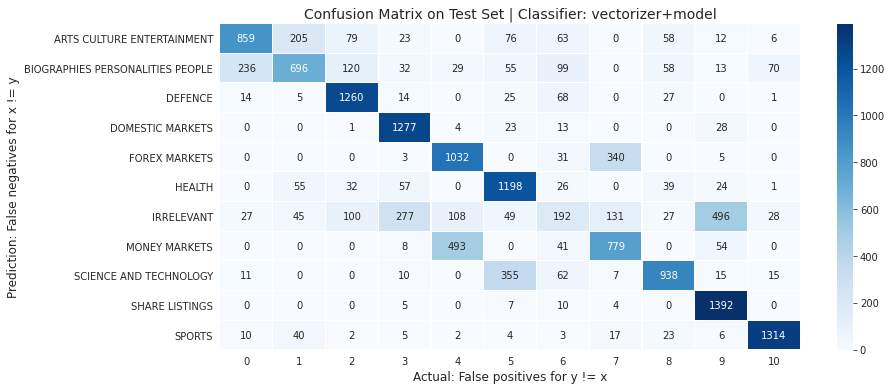

----------------------------------------------------------------------
Now,the test_df is valid_x_20
F1 score for  Pipeline  model is  0.7408080995788019
Accuracy score for  Pipeline  model is  0.7530959752321982
Recall score for  Pipeline  model is  0.7553985045818248 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.68      0.73      1381
           1       0.70      0.68      0.69      1408
           2       0.83      0.94      0.88      1414
           3       0.82      0.95      0.88      1346
           4       0.65      0.70      0.67      1411
           5       0.71      0.91      0.79      1432
           6       0.45      0.21      0.29      1480
           7       0.61     

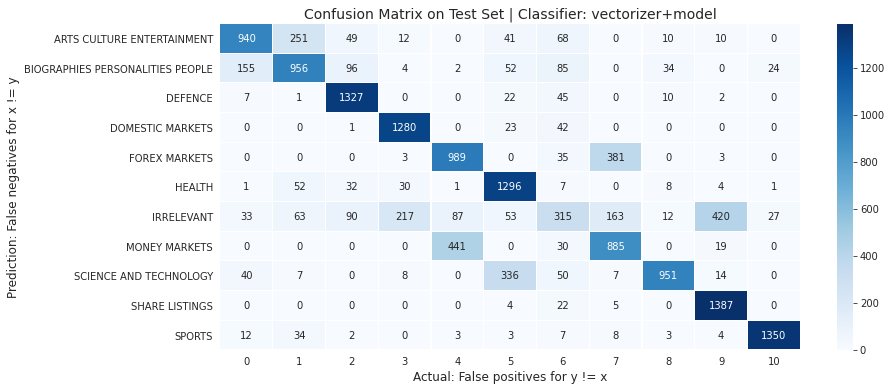

----------------------------------------------------------------------
Now,the test_df is valid_x_50
F1 score for  Pipeline  model is  0.7987624424198337
Accuracy score for  Pipeline  model is  0.8071465428276574
Recall score for  Pipeline  model is  0.80922575870362 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1381
           1       0.78      0.80      0.79      1408
           2       0.84      0.96      0.90      1414
           3       0.87      0.97      0.91      1346
           4       0.64      0.72      0.68      1411
           5       0.79      0.93      0.85      1432
           6       0.65      0.32      0.43      1480
           7       0.64      0

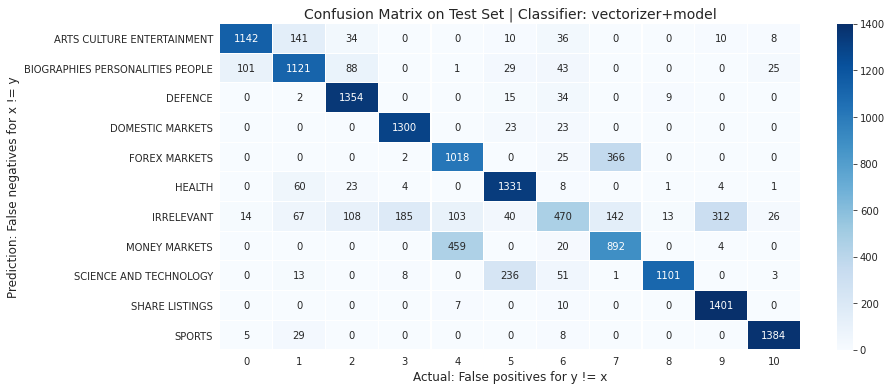

----------------------------------------------------------------------
Now,the test_df is valid_x_100
F1 score for  Pipeline  model is  0.832104107646368
Accuracy score for  Pipeline  model is  0.8360423116615067
Recall score for  Pipeline  model is  0.8377748099659977 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1381
           1       0.84      0.87      0.85      1408
           2       0.89      0.95      0.92      1414
           3       0.90      0.99      0.94      1346
           4       0.64      0.66      0.65      1411
           5       0.83      0.96      0.89      1432
           6       0.73      0.46      0.56      1480
           7       0.61     

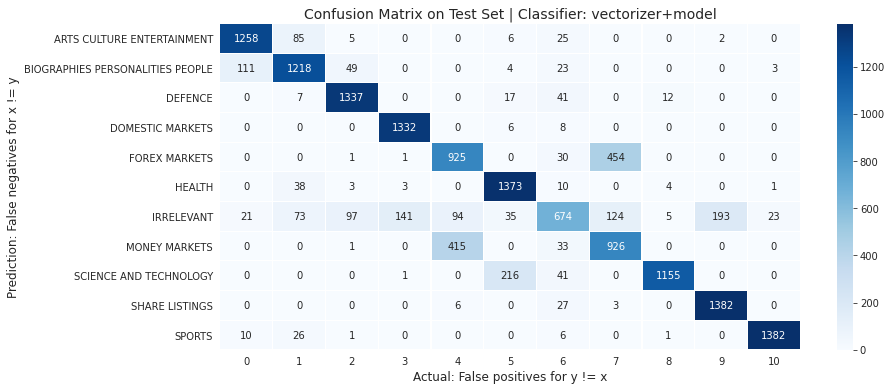

----------------------------------------------------------------------
Now,the test_df is valid_x
F1 score for  Pipeline  model is  0.833076656396831
Accuracy score for  Pipeline  model is  0.8369453044375645
Recall score for  Pipeline  model is  0.83869077560183 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1381
           1       0.83      0.87      0.85      1408
           2       0.91      0.96      0.93      1414
           3       0.90      0.99      0.94      1346
           4       0.64      0.66      0.65      1411
           5       0.84      0.95      0.89      1432
           6       0.74      0.46      0.56      1480
           7       0.62      0.67 

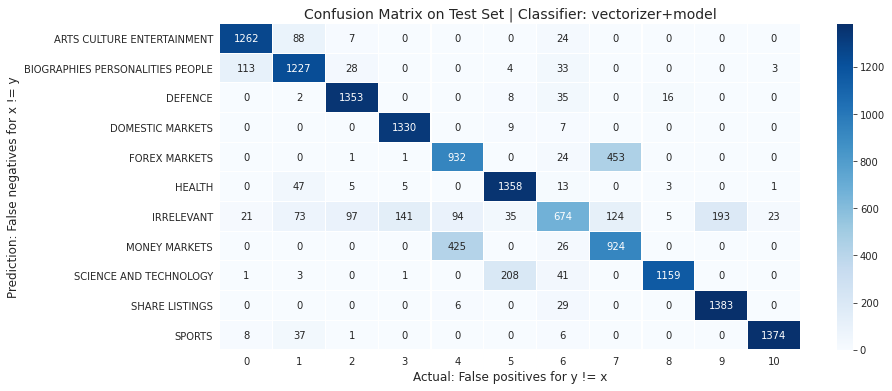

In [18]:
clf_NB_100 = None
if(count_clf_100_accuracy>=tfidf_clf_100_accuracy):
    print('count chosen')
    clf_NB_100 = count_clf_NB_100
else:
    print('tfidf chosen')
    clf_NB_100 = tfidf_clf_NB_100
rev_valid_y = le.inverse_transform(valid_y)
valid_set =[valid_x_10,valid_x_20,valid_x_50,valid_x_100,valid_x]
for ele in valid_set:
    print('----------------------------------------------------------------------')
    print(f'Now,the test_df is {namestr(ele)}') 
    df_valid = pd.DataFrame({'key_word':ele,'topic':rev_valid_y})
    test_model(df_valid,clf_NB_100,le,encode_mapping)

#### 1.7.3.2 SMOTE With CountVectorizer

In [22]:
new_train_x,smo_y,topics,le,encode_mapping = smote_data(df_train,CountVectorizer(),'article_words')
new_train_x_100,_,_,_,_ = smote_data(df_train,CountVectorizer(),'key_word_100')

In [23]:
train_x,valid_x,train_y,valid_y = train_test_split(new_train_x,smo_y,test_size=0.3,random_state=42)
valid_size = valid_x.shape[0]
train_x_100,valid_x_100,train_y,valid_y = train_test_split(new_train_x_100,smo_y,test_size=0.3,random_state=42)

##### First we build the model with train_x first.

In [21]:
%%time
# Start grid search
count_clf_NB,count_clf_accuracy = grid_search(CountVectorizer(),MultinomialNB(),\
                                              train_x,train_y,topics)
tfidf_clf_NB,tfidf_clf_accuracy = grid_search(TfidfVectorizer(norm=None),MultinomialNB(),\
                                              train_x,train_y,topics)

CPU times: user 37.5 s, sys: 3.34 s, total: 40.8 s
Wall time: 15min 56s


In [22]:
clf_NB = None
if(count_clf_accuracy>=tfidf_clf_accuracy):
    print('count chosen')
    clf_NB = count_clf_NB
else:
    print('tfidf chosen')
    clf_NB = tfidf_clf_NB

tfidf chosen


----------------------------------------------------------------------
Now,the test_df is valid_x_10
F1 score for  Pipeline  model is  0.6182848214081008
Accuracy score for  Pipeline  model is  0.6611197110423117
Recall score for  Pipeline  model is  0.6635177618675048 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.39      0.51      1381
           1       0.61      0.50      0.55      1408
           2       0.66      0.88      0.75      1414
           3       0.54      0.97      0.69      1346
           4       0.55      0.95      0.70      1411
           5       0.69      0.72      0.71      1432
           6       0.91      0.01      0.01      1480
           7       0.79     

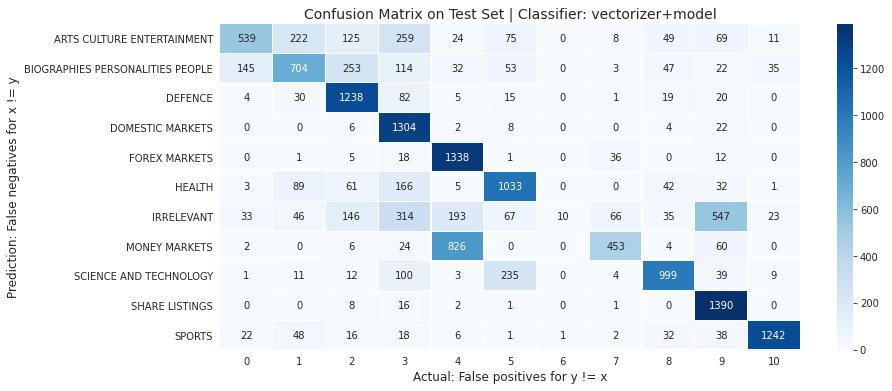

----------------------------------------------------------------------
Now,the test_df is valid_x_20
F1 score for  Pipeline  model is  0.6711941130314357
Accuracy score for  Pipeline  model is  0.7078173374613003
Recall score for  Pipeline  model is  0.7105199584304711 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.52      0.60      1381
           1       0.67      0.59      0.63      1408
           2       0.74      0.91      0.81      1414
           3       0.66      0.99      0.79      1346
           4       0.54      0.94      0.69      1411
           5       0.74      0.80      0.77      1432
           6       0.83      0.02      0.04      1480
           7       0.74     

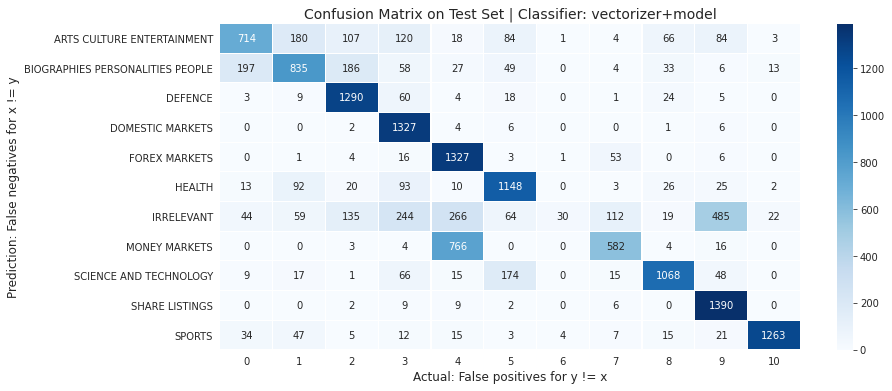

----------------------------------------------------------------------
Now,the test_df is valid_x_50
F1 score for  Pipeline  model is  0.7308612343385583
Accuracy score for  Pipeline  model is  0.7582559339525283
Recall score for  Pipeline  model is  0.7610655822537894 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.66      0.74      1381
           1       0.75      0.72      0.73      1408
           2       0.74      0.92      0.82      1414
           3       0.79      0.99      0.88      1346
           4       0.56      0.90      0.69      1411
           5       0.79      0.85      0.82      1432
           6       0.88      0.07      0.13      1480
           7       0.66     

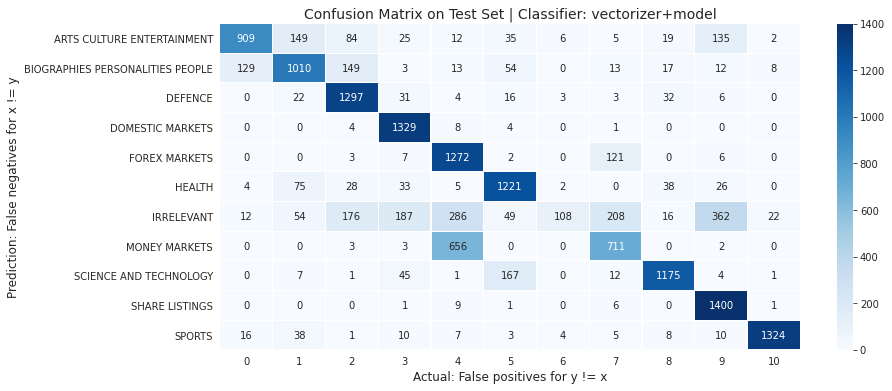

----------------------------------------------------------------------
Now,the test_df is valid_x_100
F1 score for  Pipeline  model is  0.7859317370418019
Accuracy score for  Pipeline  model is  0.7997291021671826
Recall score for  Pipeline  model is  0.8019479008067528 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.75      0.80      1381
           1       0.80      0.79      0.79      1408
           2       0.81      0.93      0.87      1414
           3       0.84      0.98      0.91      1346
           4       0.58      0.87      0.70      1411
           5       0.85      0.87      0.86      1432
           6       0.87      0.24      0.37      1480
           7       0.64    

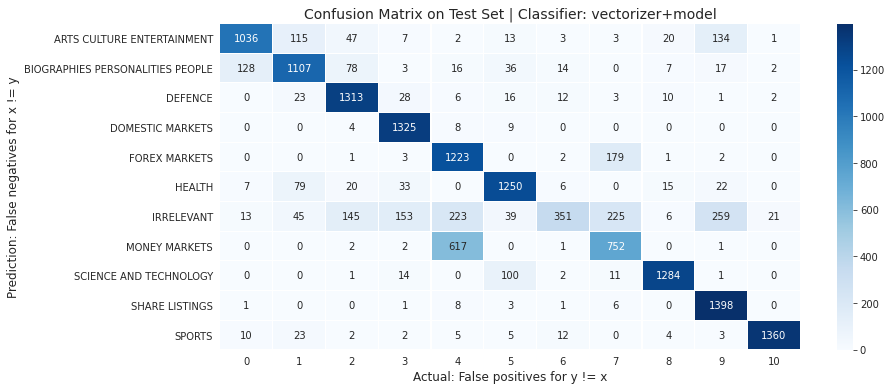

----------------------------------------------------------------------
Now,the test_df is valid_x
F1 score for  Pipeline  model is  0.9303539042327637
Accuracy score for  Pipeline  model is  0.9300825593395253
Recall score for  Pipeline  model is  0.930055853282677 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1381
           1       0.99      0.98      0.98      1408
           2       0.99      0.97      0.98      1414
           3       0.99      0.98      0.99      1346
           4       0.73      0.86      0.79      1411
           5       0.99      0.98      0.99      1432
           6       0.83      0.84      0.84      1480
           7       0.77      0.6

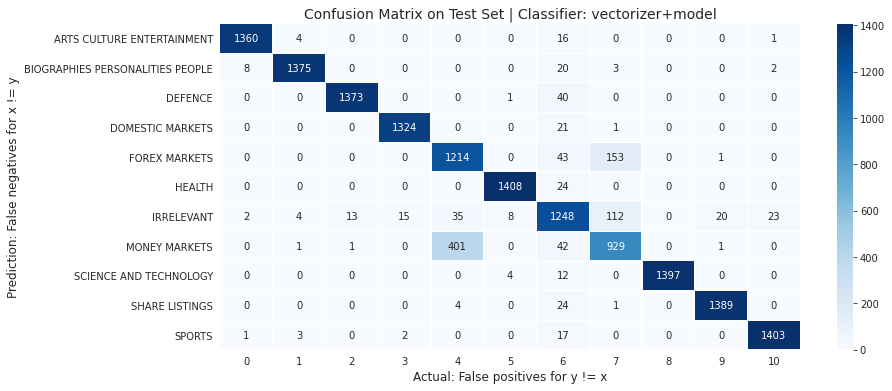

In [23]:
# reverse valid_y
rev_valid_y = le.inverse_transform(valid_y)
valid_set =[valid_x_10,valid_x_20,valid_x_50,valid_x_100,valid_x]
for ele in valid_set:
    print('----------------------------------------------------------------------')
    print(f'Now,the test_df is {namestr(ele)}') 
    df_valid = pd.DataFrame({'key_word':ele,'topic':rev_valid_y})
    test_model(df_valid,clf_NB,le,encode_mapping)

##### Now we try with train_x_100

In [24]:
%%time
# Start grid search
count_clf_NB_100,count_clf_100_accuracy = grid_search(CountVectorizer(),MultinomialNB(),\
                                              train_x_100,train_y,topics)
tfidf_clf_NB_100,tfidf_clf_100_accuracy = grid_search(TfidfVectorizer(norm=None),MultinomialNB(),\
                                              train_x_100,train_y,topics)

CPU times: user 26.8 s, sys: 2.04 s, total: 28.9 s
Wall time: 10min 10s


count chosen
----------------------------------------------------------------------
Now,the test_df is valid_x_10
F1 score for  Pipeline  model is  0.6711901000023661
Accuracy score for  Pipeline  model is  0.6928246815592396
Recall score for  Pipeline  model is  0.6923134261638659 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.63      0.65      1412
           1       0.54      0.62      0.58      1416
           2       0.82      0.88      0.85      1371
           3       0.77      0.92      0.84      1407
           4       0.61      0.92      0.73      1480
           5       0.64      0.79      0.71      1446
           6       0.22      0.10      0.13      1418
           7   

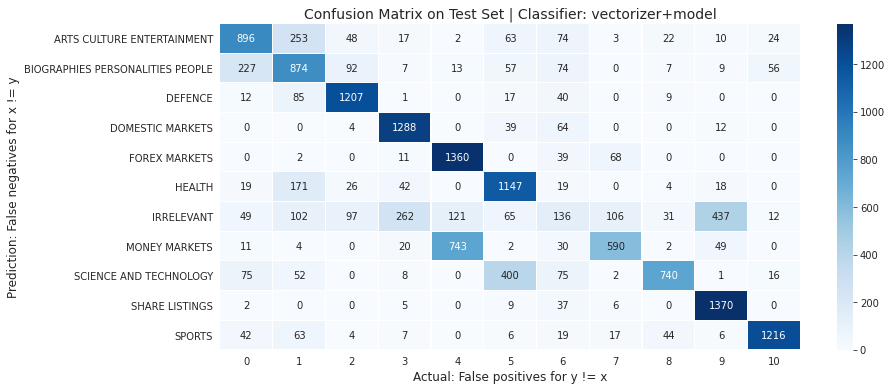

----------------------------------------------------------------------
Now,the test_df is valid_x_20
F1 score for  Pipeline  model is  0.7176578483425889
Accuracy score for  Pipeline  model is  0.724316712539205
Recall score for  Pipeline  model is  0.7237874760333548 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      1412
           1       0.67      0.73      0.70      1416
           2       0.86      0.90      0.88      1371
           3       0.85      0.83      0.84      1407
           4       0.61      0.82      0.70      1480
           5       0.66      0.90      0.76      1446
           6       0.31      0.25      0.27      1418
           7       0.68      

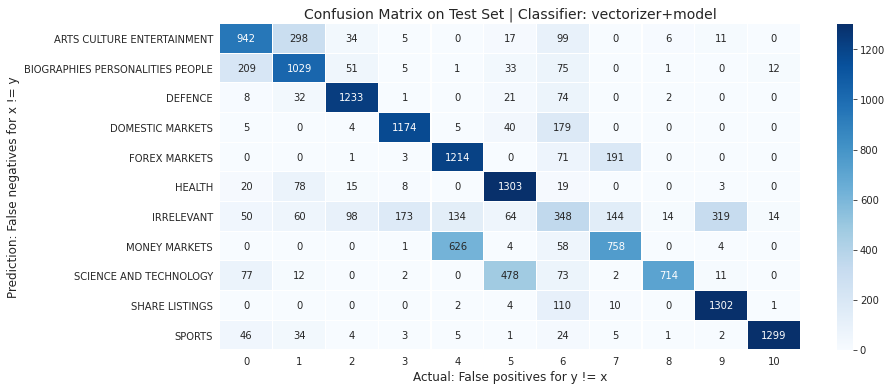

----------------------------------------------------------------------
Now,the test_df is valid_x_50
F1 score for  Pipeline  model is  0.7201098888152814
Accuracy score for  Pipeline  model is  0.7091467707866607
Recall score for  Pipeline  model is  0.7090504508369878 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.57      0.69      1412
           1       0.67      0.81      0.73      1416
           2       0.85      0.91      0.88      1371
           3       0.91      0.64      0.75      1407
           4       0.62      0.66      0.64      1480
           5       0.70      0.85      0.77      1446
           6       0.29      0.51      0.37      1418
           7       0.65     

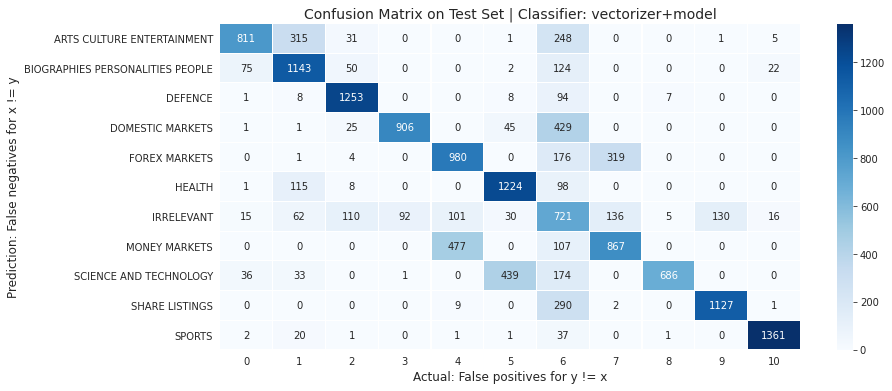

----------------------------------------------------------------------
Now,the test_df is valid_x_100
F1 score for  Pipeline  model is  0.8356639865954901
Accuracy score for  Pipeline  model is  0.8348588619343276
Recall score for  Pipeline  model is  0.8358824144433243 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1412
           1       0.80      0.84      0.82      1416
           2       0.88      0.91      0.90      1371
           3       0.93      0.96      0.95      1407
           4       0.66      0.74      0.70      1480
           5       0.85      0.87      0.86      1446
           6       0.71      0.67      0.69      1418
           7       0.67    

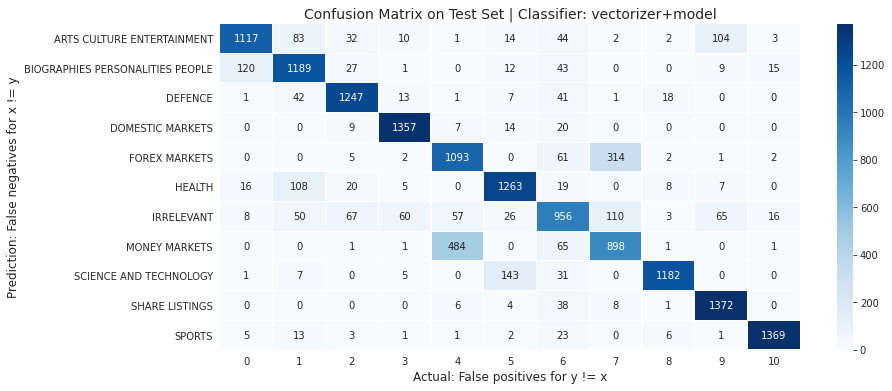

----------------------------------------------------------------------
Now,the test_df is valid_x
F1 score for  Pipeline  model is  0.8383882584544057
Accuracy score for  Pipeline  model is  0.8373551814632273
Recall score for  Pipeline  model is  0.8383183219212792 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1412
           1       0.80      0.86      0.83      1416
           2       0.89      0.91      0.90      1371
           3       0.94      0.96      0.95      1407
           4       0.67      0.74      0.70      1480
           5       0.82      0.86      0.84      1446
           6       0.72      0.67      0.69      1418
           7       0.67      0.

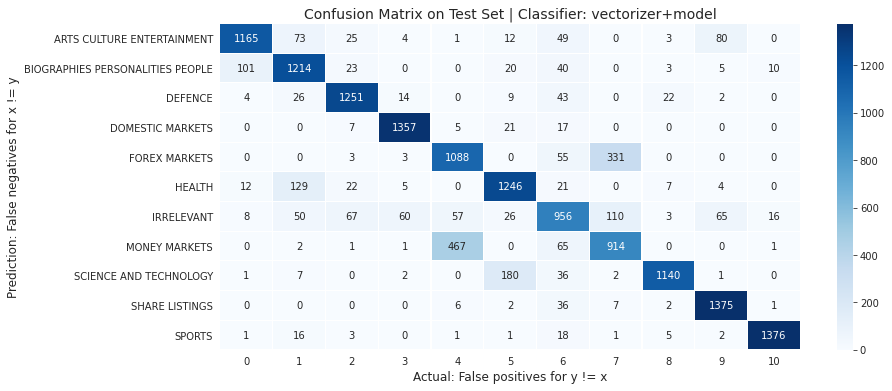

In [25]:
clf_NB_100 = None
if(count_clf_100_accuracy>=tfidf_clf_100_accuracy):
    print('count chosen')
    clf_NB_100 = count_clf_NB_100
else:
    print('tfidf chosen')
    clf_NB_100 = tfidf_clf_NB_100
rev_valid_y = le.inverse_transform(valid_y)
valid_set =[valid_x_10,valid_x_20,valid_x_50,valid_x_100,valid_x]
for ele in valid_set:
    print('----------------------------------------------------------------------')
    print(f'Now,the test_df is {namestr(ele)}') 
    df_valid = pd.DataFrame({'key_word':ele,'topic':rev_valid_y})
    test_model(df_valid,clf_NB_100,le,encode_mapping)

## 1.8 Logistic Regression Model

In Logistic Regression Model, we find out the best estimator parameters *W* by calculating the **maximum likelihood estimator**. The likelihood function is given as:<br>
<div align='middle'>$\begin{align*}L(W)&=\sum_{i=1}^{n}lnp(y_{i}|X_{i},W)\\
&=\sum_{i=1}^{n}ln(\phi (z_{i})^{y_{i}}(1-\phi (z_{i}))^{1-y_{i}})\\
&=\sum_{i=1}^{n}ln\phi (z_{i})+(1-y_{i})ln(1-\phi (z_{i}))
\end{align*}$</div> <br>
By calculating the derivative of likelihood function, we can get the loss function:<br>
<div align='middle'>
    $J(W)=-\sum_{i=1}^{n}y_{i}ln\phi (z_{i})+(1-y_{i})ln(1-\phi (z_{i}))$
</div><br>


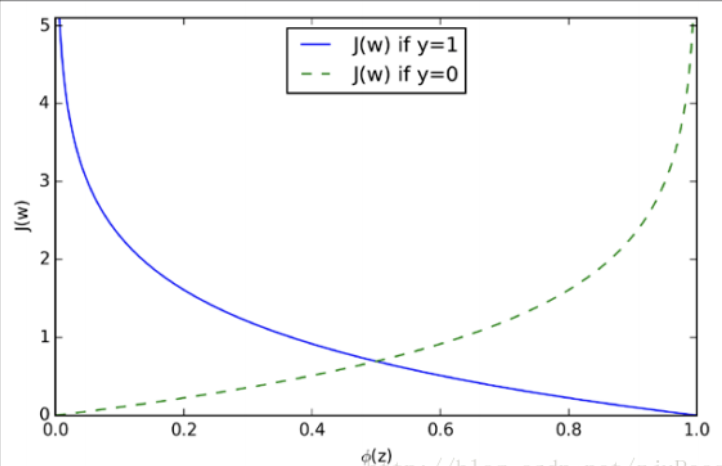</img>

Using a property of Sigmoid function $\phi (z)$:<br>
<div align='middle'>$\phi (z)'=\phi (z)(1-\phi(z))$</div><br>
We can have the following formula to update the weight parameters:<br>
<div align='middle'>$w_{j}:=w_{j}+\eta \sum_{i=1}^{n}(y_{i}-\phi (z_{i}))x_{ij}$</div>

Considering the long time for constructing Logistic Regression Models in this assignment, we just use Tfidf Vectorizer to transform original text data to vectors before data SMOTE.

### 1.8.1 Pipeline Hyper Parameter

The description of hyper parameter tuning is given below.<br>
- min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.<br>
- class_weight: Weights associated with classes in the form {class_label:weight}
- multi_class: If the option chosen is 'ovr', then a binary problem is fit for each label. For 'multinomial' the loss minimised is the multinomial loss fit across the entire probability distribution, even when the data is binary.
- C: Inverse of regularization strength; must be a positive float.

Since GridSearchCV() function can find out the optimal hyper parameters for users, we do not care what exactly the optimal hyper parameters are, but just retrieve the optimal encapsulated model.

### Two Layer Model Construction

### 1.8.2 First Layer Construction

#### 1.8.2.1 encode labels to relevant: 0, irrelevent: 1

In [1]:
text_train = df_train.article_words
label_train = df_train.topic
y_train = np.where(df_train.topic == "IRRELEVANT", 0, 1)
df_train["is_relevent"] = y_train
vect = CountVectorizer(min_df=5)
X_train = vect.fit_transform(text_train)

In [46]:
%%time
# Ingore convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

# Get accuracy scores for each of 5-fold CV
# b_jobs specifies how many processors are used in paralle, -1 means all

accs = cross_val_score(LogisticRegression(n_jobs=-1), X_train, y_train, cv=5)
print(f"Mean accuracy (std): {np.mean(accs): .3f} ({np.std(accs): .3f})")

Mean accuracy (std):  0.832 ( 0.004)
CPU times: user 132 ms, sys: 81.9 ms, total: 214 ms
Wall time: 3.46 s


In [47]:
%%time
param_grid = {'C': np.geomspace(0.001,10,num=5,endpoint=True)}

grid = GridSearchCV(LogisticRegression(n_jobs=-1), param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print(f"best parameter: {grid.best_params_}")
print(f"best 5-fold CV score (accuracy): {grid.best_score_: .3f}")

best parameter: {'C': 0.01}
best 5-fold CV score (accuracy):  0.859
CPU times: user 74.1 ms, sys: 14.7 ms, total: 88.8 ms
Wall time: 4.94 s


In [48]:
%%time
text_test = df_test.article_words # training set containing text content
label_test = df_test.topic

# encode labels to relevant: 0, irrelevent: 1
y_test = np.where(df_test.topic == "IRRELEVANT", 0, 1)
y_test.sum()

X_test = vect.transform(text_test)
acc_test = grid.score(X_test, y_test)
print(f"Logistic regression accuracy on test set: {acc_test:.3f}")

Logistic regression accuracy on test set: 0.880
CPU times: user 35.4 ms, sys: 3.49 ms, total: 38.9 ms
Wall time: 38.9 ms


#### 1.8.2.2 Hyperparameter Tuning

In [49]:
# standard pipeline interface
estimators = [
              ("tfidf", TfidfVectorizer(norm=None)),
              ("LR", LogisticRegression(n_jobs=-1))
             ]

pipe = Pipeline(estimators)

# Notice here parameters need to be specified to which step in the pipeline they belong to
param_grid = {
              "tfidf__min_df": np.arange(6),
              "LR__class_weight": ["balanced", None],
              "LR__multi_class": ["ovr", "multinomial"],
              "LR__C": [0.0001, 0.01, 0.1, 1, 10],
             }
pipe

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm=None,
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('LR',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [50]:
%%time
grid = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1)

# pass in original text samples
grid.fit(text_train, y_train)

# Extract the optimal steps we have obtained sofar
clf_logi = grid.best_estimator_

# Report accuracy scores on training and test set
acc_train = grid.best_score_
print(f"Best parameter: {grid.best_params_}")
print(f"Accuracy on training set: {acc_train:.3f}")

/import/ravel/1/z5244619/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best parameter: {'LR__C': 0.0001, 'LR__class_weight': None, 'LR__multi_class': 'multinomial', 'tfidf__min_df': 4}
Accuracy on training set: 0.865
CPU times: user 12.6 s, sys: 4.37 s, total: 17 s
Wall time: 14min 57s


In [2]:
save_variable(clf_logi,'best_logi_layer1')

### 1.8.3 Second Layer Construction

In [5]:
new_train_x,smo_y,topics,le,encode_mapping = smote_data(df_train,TfidfVectorizer(),'article_words')
new_train_x_10,_,_,_,_ = smote_data(df_train,TfidfVectorizer(),'key_word_10')
new_train_x_20,_,_,_,_ = smote_data(df_train,TfidfVectorizer(),'key_word_20')
new_train_x_50,_,_,_,_ = smote_data(df_train,TfidfVectorizer(),'key_word_50')
new_train_x_100,_,_,_,_ = smote_data(df_train,TfidfVectorizer(),'key_word_100')

In [8]:
train_x,valid_x,train_y,valid_y = train_test_split(new_train_x,smo_y,test_size=0.3,random_state=42)
train_x_10,valid_x_10,train_y,valid_y = train_test_split(new_train_x_10,smo_y,test_size=0.3,random_state=42)
train_x_20,valid_x_20,train_y,valid_y = train_test_split(new_train_x_20,smo_y,test_size=0.3,random_state=42)
train_x_50,valid_x_50,train_y,valid_y = train_test_split(new_train_x_50,smo_y,test_size=0.3,random_state=42)
train_x_100,valid_x_100,train_y,valid_y = train_test_split(new_train_x_100,smo_y,test_size=0.3,random_state=42)

In [10]:
train_collection = {
    'train10': train_x_10,
    'train20': train_x_20,
    'train50': train_x_50,
    'train100': train_x_100,
    'trainfull': train_x,
}

valid_collection = {
    'valid10': valid_x_10,
    'valid20': valid_x_20,
    'valid50': valid_x_50,
    'valid100': valid_x_100,
    'validfull': valid_x,
}

We modify the get_model() function here.

In [1]:
def get_model(df_name, x, y):
    # Start grid search
    grid_count = grid_search(CountVectorizer(),LogisticRegression(),\
                                                  x,y,topics)
    grid_tfidf = grid_search(TfidfVectorizer(norm=None),LogisticRegression(),\
                                                  x,y,topics)
    
    count_clf_logi,count_clf_accuracy = grid_count.best_estimator_, grid_count.best_score_
    tfidf_clf_logi,tfidf_clf_accuracy = grid_tfidf.best_estimator_, grid_tfidf.best_score_
    
    if(count_clf_accuracy>=tfidf_clf_accuracy):
        # Export the better model
        save_variable(grid_count, f"count+{df_name}_smotwithtfidf")
        print(f'*************************************************************')
        print(f'Now the training set is {df_name}, and the model chosen is count_clf_logi')
        print(f'The accuracy is {count_clf_accuracy}')
        return count_clf_logi
    else:
        save_variable(grid_tfidf, f"tfidf+{df_name}_smotwithtfidf")
        print(f'*************************************************************')
        print(f'Now the training set is {df_name}, and the model chosen is tfidf_clf_logi')
        print(f'The accuracy is {tfidf_clf_accuracy}')
        return tfidf_clf_logi
    

*************************************************************
Now the training set is train10, and the model chosen is count_clf_logi
The accuracy is 0.8321994533827957
----------------------------------------------------------------------
Now, the train_df is train10, the validation_df is valid10
F1 score for  Pipeline  model is  0.8315632294925894
Accuracy score for  Pipeline  model is  0.8328173374613003
Recall score for  Pipeline  model is  0.8334167573997159 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1381
           1       0.77      0.79      0.78      1408
           2       0.93      0.91      0.92      1414
           3       0.95      0.98      0.96   

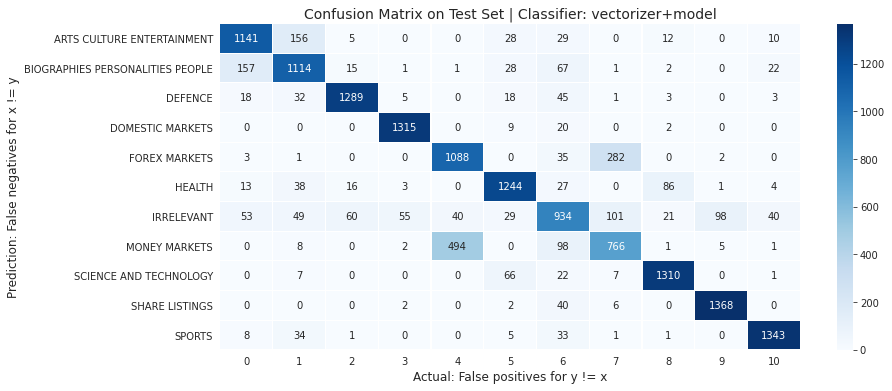

----------------------------------------------------------------------
Now, the train_df is train10, the validation_df is valid20
F1 score for  Pipeline  model is  0.838806315055573
Accuracy score for  Pipeline  model is  0.8406217750257998
Recall score for  Pipeline  model is  0.8411692470638763 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1381
           1       0.79      0.83      0.81      1408
           2       0.92      0.94      0.93      1414
           3       0.95      0.97      0.96      1346
           4       0.66      0.77      0.71      1411
           5       0.88      0.86      0.87      1432
           6       0.74      0.63      0.68      1480


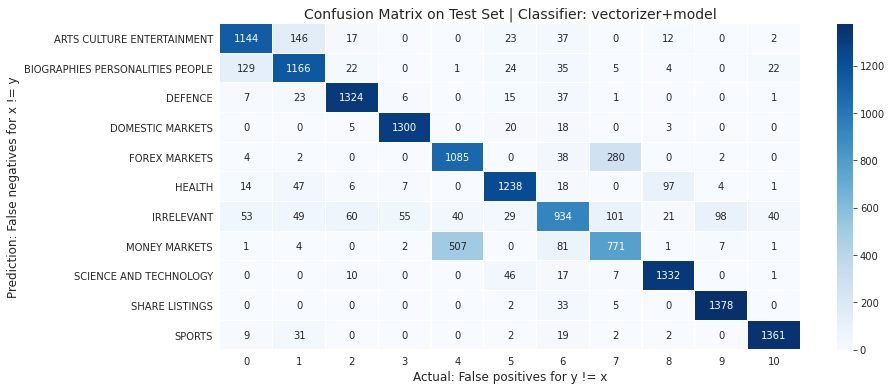

----------------------------------------------------------------------
Now, the train_df is train10, the validation_df is valid50
F1 score for  Pipeline  model is  0.8377774216835063
Accuracy score for  Pipeline  model is  0.8397832817337462
Recall score for  Pipeline  model is  0.8402974930013829 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1381
           1       0.82      0.83      0.82      1408
           2       0.92      0.94      0.93      1414
           3       0.94      0.95      0.95      1346
           4       0.66      0.77      0.71      1411
           5       0.87      0.86      0.87      1432
           6       0.75      0.63      0.68      1480

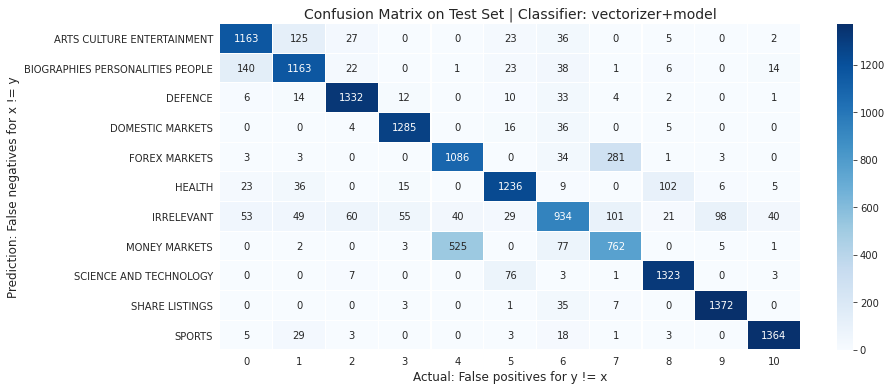

----------------------------------------------------------------------
Now, the train_df is train10, the validation_df is valid100
F1 score for  Pipeline  model is  0.8373786327610571
Accuracy score for  Pipeline  model is  0.8393962848297214
Recall score for  Pipeline  model is  0.8399934844573618 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1381
           1       0.81      0.83      0.82      1408
           2       0.91      0.93      0.92      1414
           3       0.93      0.96      0.95      1346
           4       0.66      0.78      0.71      1411
           5       0.87      0.85      0.86      1432
           6       0.76      0.63      0.69      148

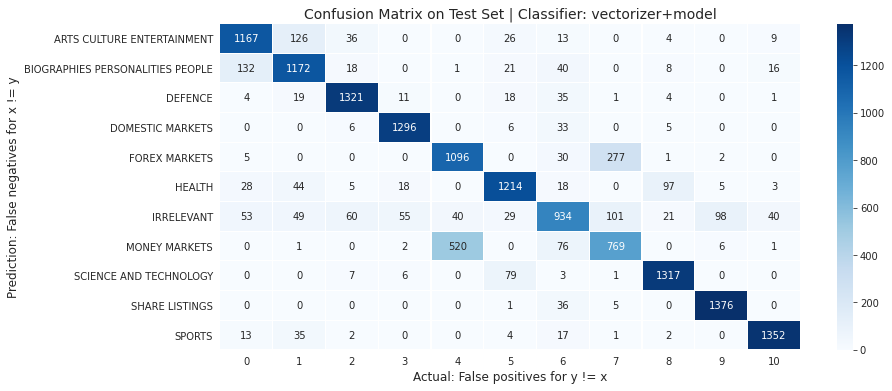

----------------------------------------------------------------------
Now, the train_df is train10, the validation_df is validfull
F1 score for  Pipeline  model is  0.8333247509429921
Accuracy score for  Pipeline  model is  0.8351393188854489
Recall score for  Pipeline  model is  0.8357222060578569 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1381
           1       0.80      0.84      0.82      1408
           2       0.91      0.92      0.91      1414
           3       0.94      0.97      0.95      1346
           4       0.66      0.78      0.71      1411
           5       0.84      0.85      0.84      1432
           6       0.74      0.63      0.68      14

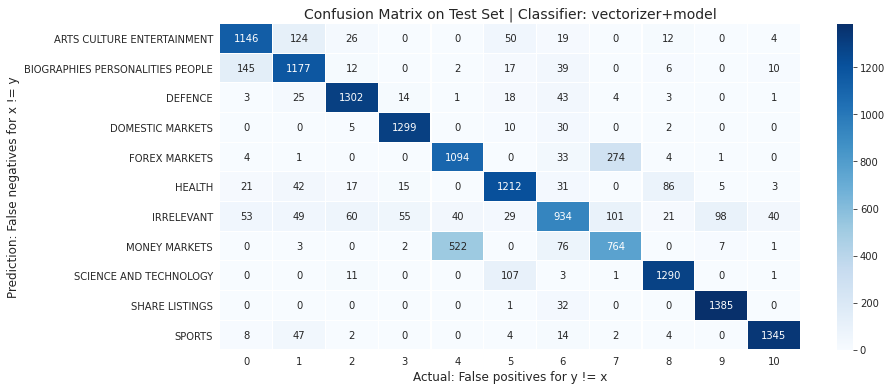

*************************************************************
Now the training set is train20, and the model chosen is tfidf_clf_logi
The accuracy is 0.8933762438384063
----------------------------------------------------------------------
Now, the train_df is train20, the validation_df is valid10
F1 score for  Pipeline  model is  0.7245456736600464
Accuracy score for  Pipeline  model is  0.719749742002064
Recall score for  Pipeline  model is  0.7198050957825186 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.67      0.70      1381
           1       0.66      0.52      0.58      1408
           2       0.94      0.81      0.87      1414
           3       0.83      0.95      0.89    

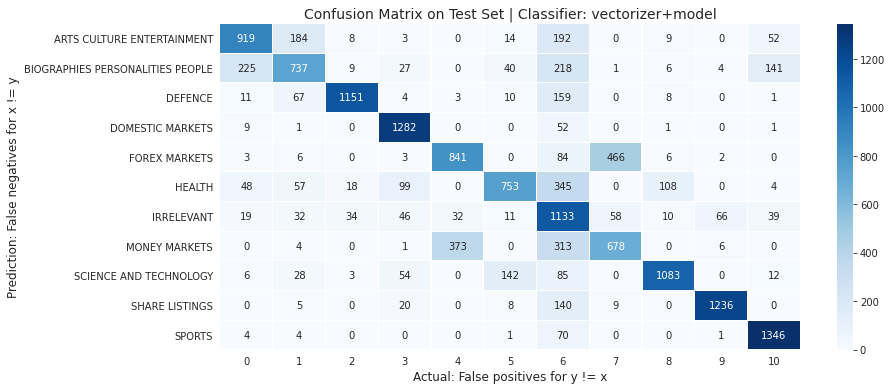

----------------------------------------------------------------------
Now, the train_df is train20, the validation_df is valid20
F1 score for  Pipeline  model is  0.890130582328982
Accuracy score for  Pipeline  model is  0.8914473684210527
Recall score for  Pipeline  model is  0.8918739869342737 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1381
           1       0.89      0.92      0.91      1408
           2       0.96      0.95      0.96      1414
           3       0.97      0.99      0.98      1346
           4       0.68      0.78      0.73      1411
           5       0.97      0.99      0.98      1432
           6       0.79      0.70      0.74      1480


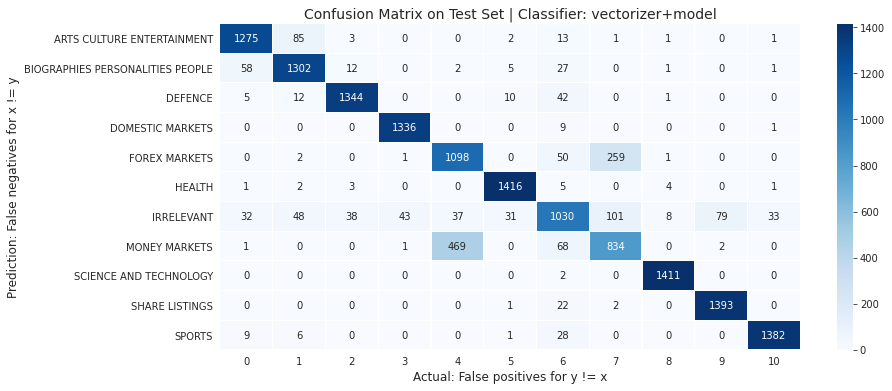

----------------------------------------------------------------------
Now, the train_df is train20, the validation_df is valid50
F1 score for  Pipeline  model is  0.8866144253151912
Accuracy score for  Pipeline  model is  0.8880288957688338
Recall score for  Pipeline  model is  0.8884391374995043 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1381
           1       0.91      0.90      0.90      1408
           2       0.96      0.96      0.96      1414
           3       0.96      0.99      0.98      1346
           4       0.68      0.78      0.72      1411
           5       0.96      0.98      0.97      1432
           6       0.80      0.70      0.74      1480

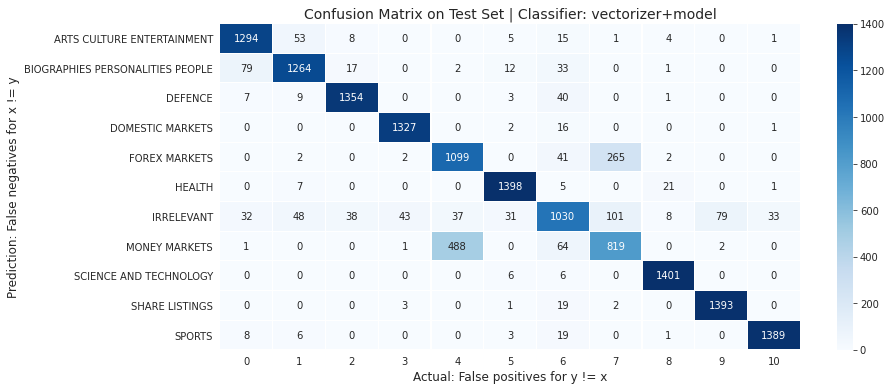

----------------------------------------------------------------------
Now, the train_df is train20, the validation_df is valid100
F1 score for  Pipeline  model is  0.8828088593279382
Accuracy score for  Pipeline  model is  0.8840944272445821
Recall score for  Pipeline  model is  0.8844787475092548 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1381
           1       0.89      0.90      0.90      1408
           2       0.95      0.95      0.95      1414
           3       0.96      0.99      0.97      1346
           4       0.68      0.78      0.73      1411
           5       0.95      0.97      0.96      1432
           6       0.79      0.70      0.74      148

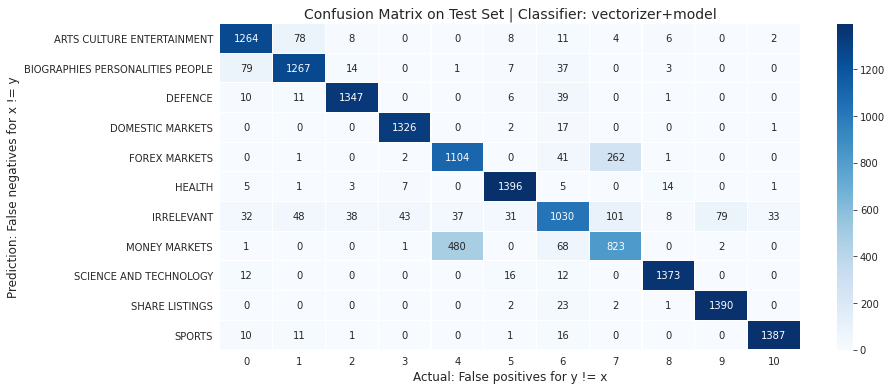

----------------------------------------------------------------------
Now, the train_df is train20, the validation_df is validfull
F1 score for  Pipeline  model is  0.8886725250815032
Accuracy score for  Pipeline  model is  0.8900928792569659
Recall score for  Pipeline  model is  0.8904873036310121 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1381
           1       0.91      0.92      0.92      1408
           2       0.96      0.95      0.95      1414
           3       0.97      0.99      0.98      1346
           4       0.69      0.79      0.74      1411
           5       0.96      0.98      0.97      1432
           6       0.80      0.70      0.74      14

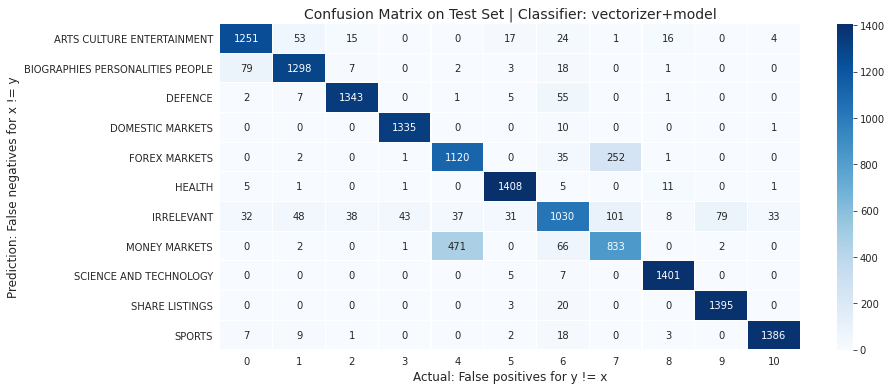

*************************************************************
Now the training set is train50, and the model chosen is tfidf_clf_logi
The accuracy is 0.9283739811677949
----------------------------------------------------------------------
Now, the train_df is train50, the validation_df is valid10
F1 score for  Pipeline  model is  0.5104490875262333
Accuracy score for  Pipeline  model is  0.4871001031991744
Recall score for  Pipeline  model is  0.48665126627138816 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.37      0.53      1381
           1       0.67      0.44      0.53      1408
           2       0.98      0.24      0.38      1414
           3       0.71      0.78      0.74  

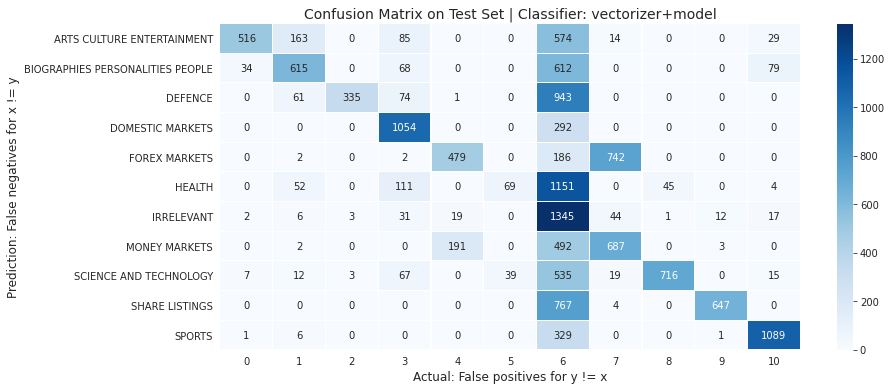

----------------------------------------------------------------------
Now, the train_df is train50, the validation_df is valid20
F1 score for  Pipeline  model is  0.7136348554693782
Accuracy score for  Pipeline  model is  0.6773090815273478
Recall score for  Pipeline  model is  0.6756051210586261 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.64      0.74      1381
           1       0.77      0.68      0.72      1408
           2       0.98      0.53      0.69      1414
           3       0.94      0.61      0.74      1346
           4       0.70      0.61      0.65      1411
           5       0.92      0.62      0.74      1432
           6       0.27      0.89      0.42      1480

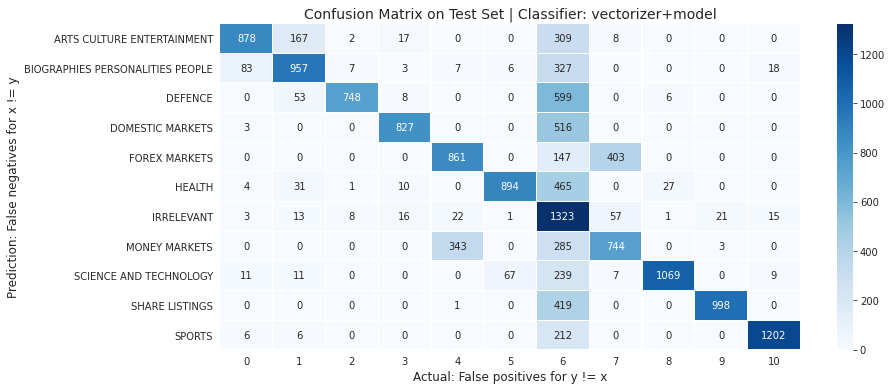

----------------------------------------------------------------------
Now, the train_df is train50, the validation_df is valid50
F1 score for  Pipeline  model is  0.9253028501230499
Accuracy score for  Pipeline  model is  0.925954592363261
Recall score for  Pipeline  model is  0.9261826072296614 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1381
           1       0.97      0.99      0.98      1408
           2       0.97      0.98      0.97      1414
           3       0.98      1.00      0.99      1346
           4       0.72      0.81      0.76      1411
           5       0.99      0.99      0.99      1432
           6       0.87      0.79      0.83      1480


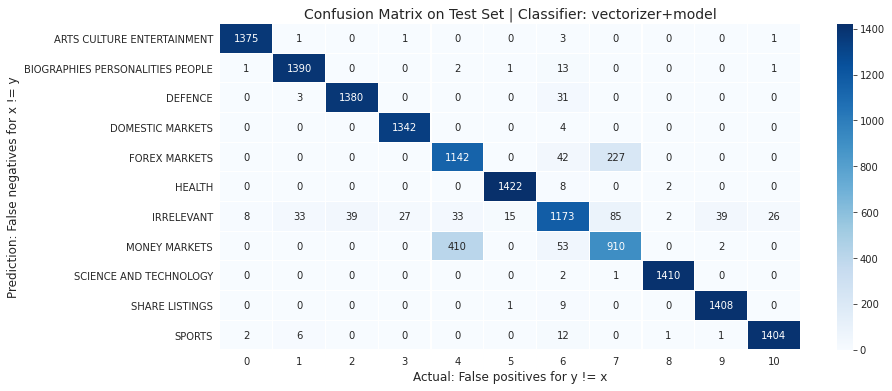

----------------------------------------------------------------------
Now, the train_df is train50, the validation_df is valid100
F1 score for  Pipeline  model is  0.9213759989841801
Accuracy score for  Pipeline  model is  0.921891124871001
Recall score for  Pipeline  model is  0.9221224746811812 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1381
           1       0.97      0.98      0.97      1408
           2       0.97      0.97      0.97      1414
           3       0.98      1.00      0.99      1346
           4       0.72      0.78      0.75      1411
           5       0.99      0.99      0.99      1432
           6       0.86      0.79      0.83      1480

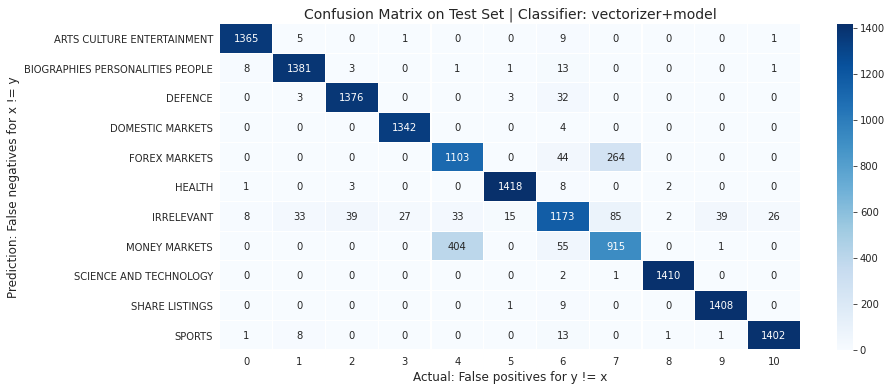

----------------------------------------------------------------------
Now, the train_df is train50, the validation_df is validfull
F1 score for  Pipeline  model is  0.9212665645809487
Accuracy score for  Pipeline  model is  0.9216976264189887
Recall score for  Pipeline  model is  0.9219499826378034 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1381
           1       0.96      0.98      0.97      1408
           2       0.97      0.96      0.97      1414
           3       0.98      1.00      0.99      1346
           4       0.72      0.80      0.76      1411
           5       0.98      0.99      0.99      1432
           6       0.85      0.79      0.82      14

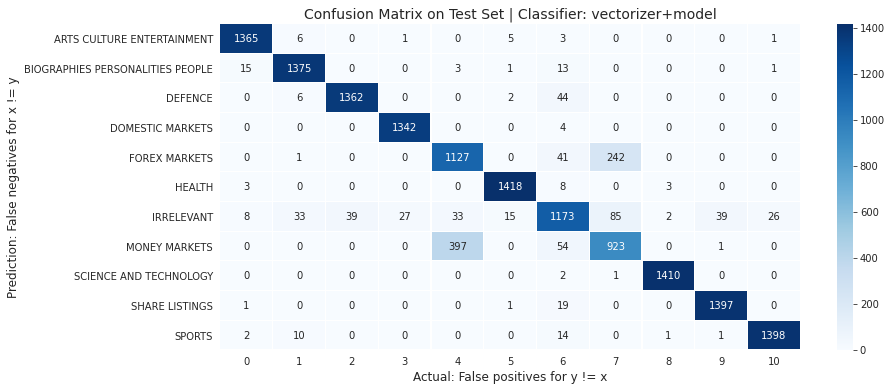

*************************************************************
Now the training set is train100, and the model chosen is count_clf_logi
The accuracy is 0.9365566188044203
----------------------------------------------------------------------
Now, the train_df is train100, the validation_df is valid10
F1 score for  Pipeline  model is  0.4134943810653207
Accuracy score for  Pipeline  model is  0.39493034055727555
Recall score for  Pipeline  model is  0.39426581934256233 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.21      0.34      1381
           1       0.75      0.26      0.38      1408
           2       1.00      0.15      0.26      1414
           3       0.64      0.77      0.7

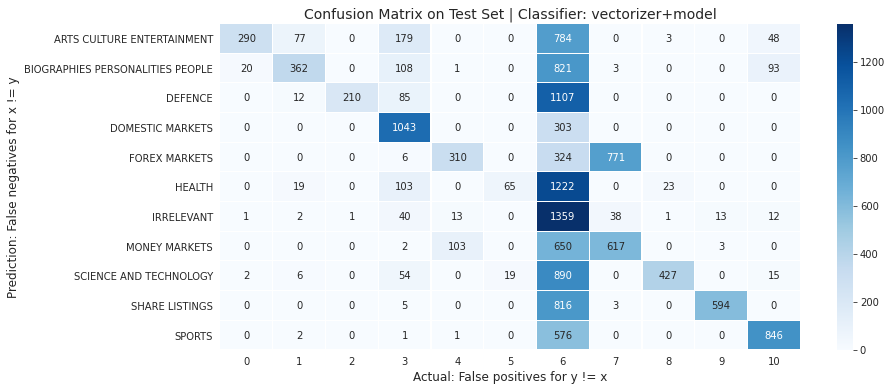

----------------------------------------------------------------------
Now, the train_df is train100, the validation_df is valid20
F1 score for  Pipeline  model is  0.6149633137618146
Accuracy score for  Pipeline  model is  0.5654669762641898
Recall score for  Pipeline  model is  0.5626123241044668 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.48      0.63      1381
           1       0.78      0.61      0.69      1408
           2       0.94      0.51      0.66      1414
           3       0.88      0.35      0.50      1346
           4       0.67      0.45      0.54      1411
           5       0.89      0.47      0.62      1432
           6       0.21      0.91      0.34      148

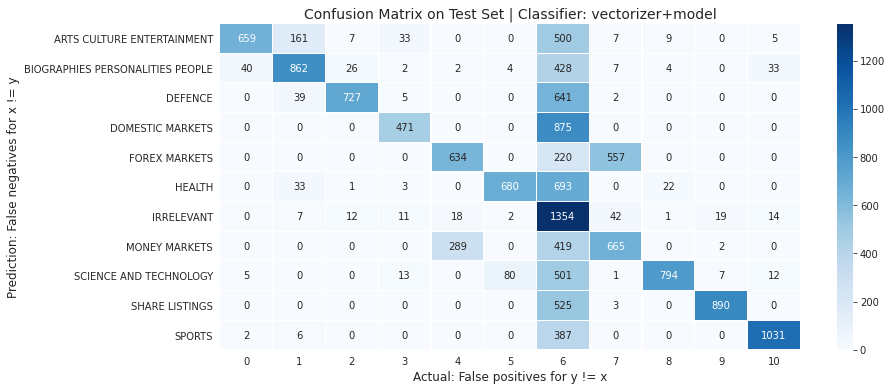

----------------------------------------------------------------------
Now, the train_df is train100, the validation_df is valid50
F1 score for  Pipeline  model is  0.8577507273563053
Accuracy score for  Pipeline  model is  0.8547471620227038
Recall score for  Pipeline  model is  0.8539369509688648 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.70      0.82      1381
           1       0.87      0.91      0.89      1408
           2       0.95      0.94      0.94      1414
           3       0.97      0.88      0.92      1346
           4       0.71      0.72      0.72      1411
           5       0.95      0.94      0.94      1432
           6       0.59      0.82      0.69      148

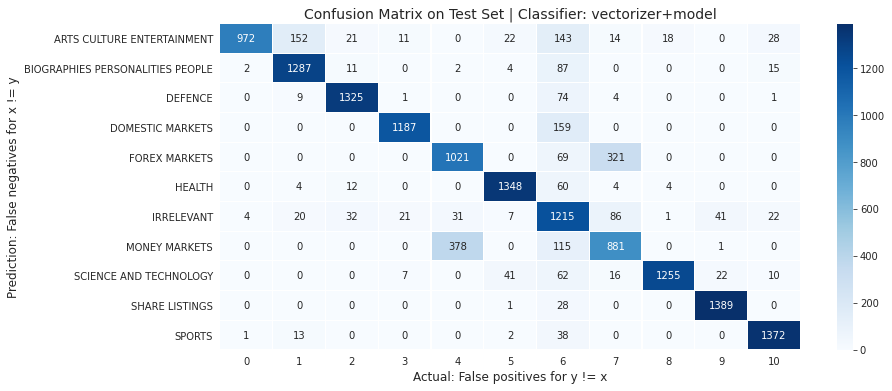

----------------------------------------------------------------------
Now, the train_df is train100, the validation_df is valid100
F1 score for  Pipeline  model is  0.9352434565143148
Accuracy score for  Pipeline  model is  0.9357585139318886
Recall score for  Pipeline  model is  0.9360213570708247 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1381
           1       0.98      0.99      0.99      1408
           2       0.98      0.98      0.98      1414
           3       0.98      1.00      0.99      1346
           4       0.75      0.82      0.79      1411
           5       0.99      1.00      0.99      1432
           6       0.90      0.81      0.85      14

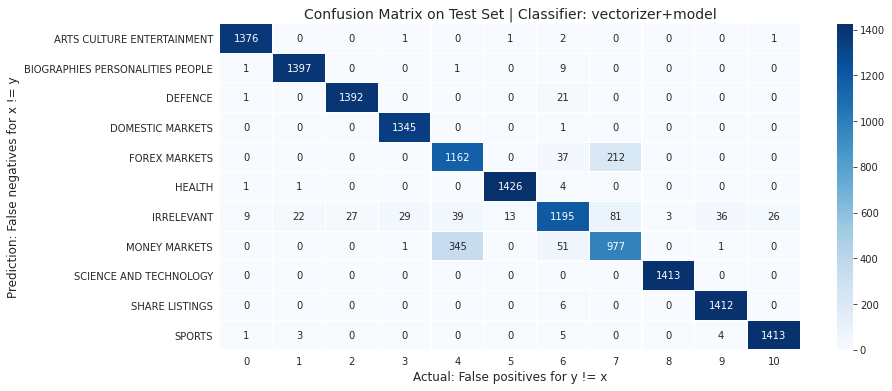

----------------------------------------------------------------------
Now, the train_df is train100, the validation_df is validfull
F1 score for  Pipeline  model is  0.9342530712040436
Accuracy score for  Pipeline  model is  0.9346620227038184
Recall score for  Pipeline  model is  0.9349444292744672 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1381
           1       0.98      0.99      0.98      1408
           2       0.98      0.98      0.98      1414
           3       0.98      1.00      0.99      1346
           4       0.75      0.82      0.78      1411
           5       0.99      1.00      0.99      1432
           6       0.89      0.81      0.85      1

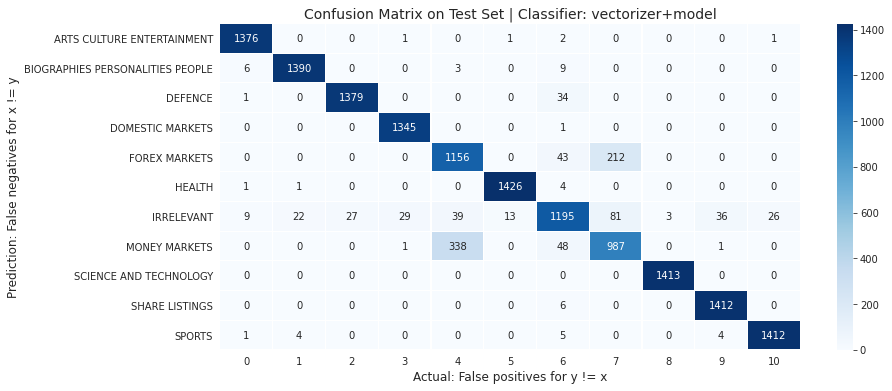

*************************************************************
Now the training set is trainfull, and the model chosen is tfidf_clf_logi
The accuracy is 0.9703655103281246
----------------------------------------------------------------------
Now, the train_df is trainfull, the validation_df is valid10
F1 score for  Pipeline  model is  0.32424207769103197
Accuracy score for  Pipeline  model is  0.34520123839009287
Recall score for  Pipeline  model is  0.34242142043007423 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.01      1381
           1       0.85      0.03      0.06      1408
           2       0.97      0.19      0.31      1414
           3       0.74      0.23      

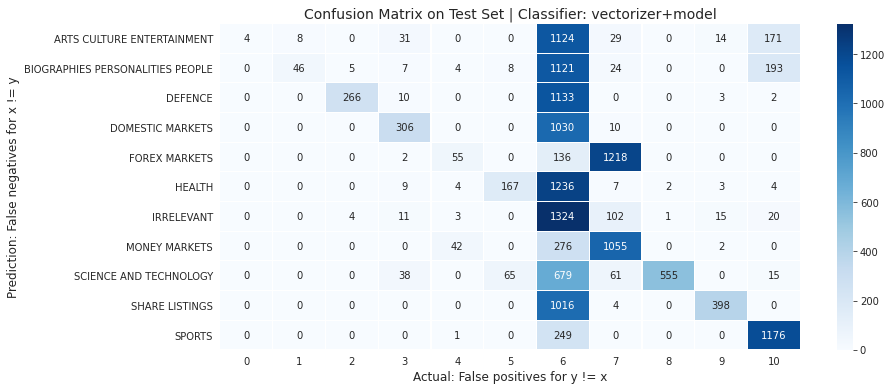

----------------------------------------------------------------------
Now, the train_df is trainfull, the validation_df is valid20
F1 score for  Pipeline  model is  0.4047999641191472
Accuracy score for  Pipeline  model is  0.39647832817337464
Recall score for  Pipeline  model is  0.39284328481690395 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.13      0.23      1381
           1       0.81      0.20      0.32      1408
           2       0.93      0.43      0.58      1414
           3       0.92      0.10      0.17      1346
           4       0.60      0.07      0.12      1411
           5       0.70      0.25      0.37      1432
           6       0.15      0.90      0.26      

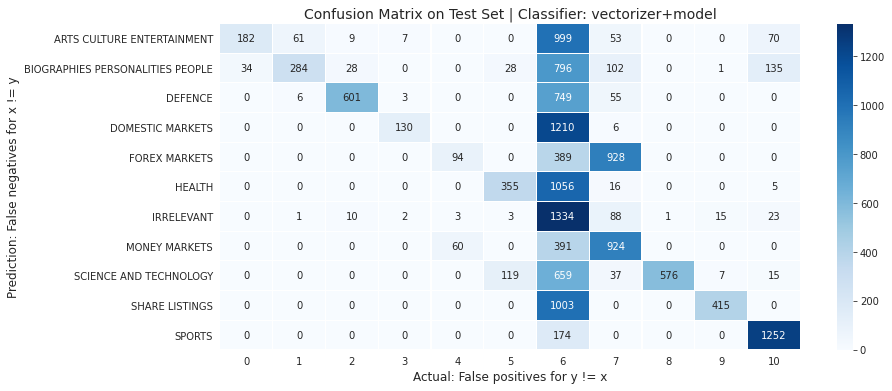

----------------------------------------------------------------------
Now, the train_df is trainfull, the validation_df is valid50
F1 score for  Pipeline  model is  0.5740290517592714
Accuracy score for  Pipeline  model is  0.5661764705882353
Recall score for  Pipeline  model is  0.5627024067120832 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.15      0.25      1381
           1       0.86      0.36      0.51      1408
           2       0.93      0.71      0.80      1414
           3       0.96      0.25      0.39      1346
           4       0.62      0.30      0.40      1411
           5       0.80      0.49      0.61      1432
           6       0.23      0.85      0.36      14

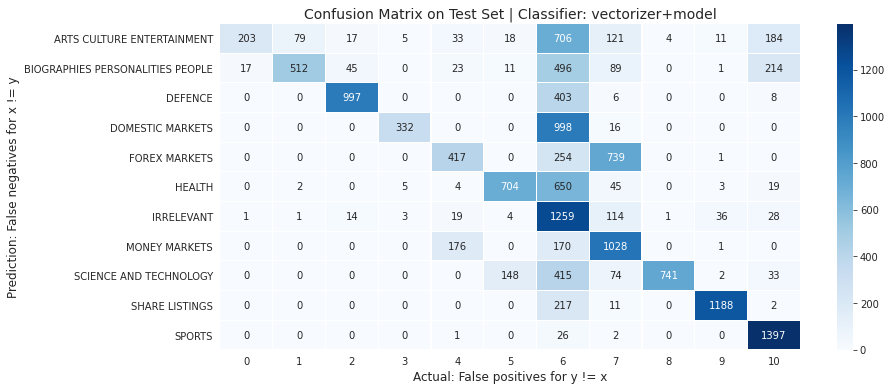

----------------------------------------------------------------------
Now, the train_df is trainfull, the validation_df is valid100
F1 score for  Pipeline  model is  0.6504669056732436
Accuracy score for  Pipeline  model is  0.6231940144478845
Recall score for  Pipeline  model is  0.6205681470159733 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.39      0.55      1381
           1       0.91      0.45      0.60      1408
           2       0.95      0.72      0.82      1414
           3       0.98      0.38      0.55      1346
           4       0.70      0.26      0.37      1411
           5       0.87      0.53      0.66      1432
           6       0.23      0.87      0.37      1

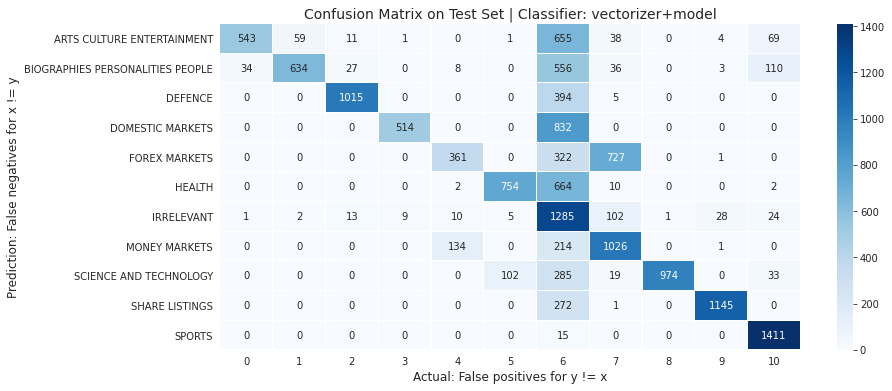

----------------------------------------------------------------------
Now, the train_df is trainfull, the validation_df is validfull
F1 score for  Pipeline  model is  0.9716847652046853
Accuracy score for  Pipeline  model is  0.9718137254901961
Recall score for  Pipeline  model is  0.9722720324723249 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1381
           1       0.99      1.00      0.99      1408
           2       0.98      1.00      0.99      1414
           3       0.99      1.00      1.00      1346
           4       0.90      0.95      0.93      1411
           5       0.99      1.00      1.00      1432
           6       0.97      0.85      0.91      

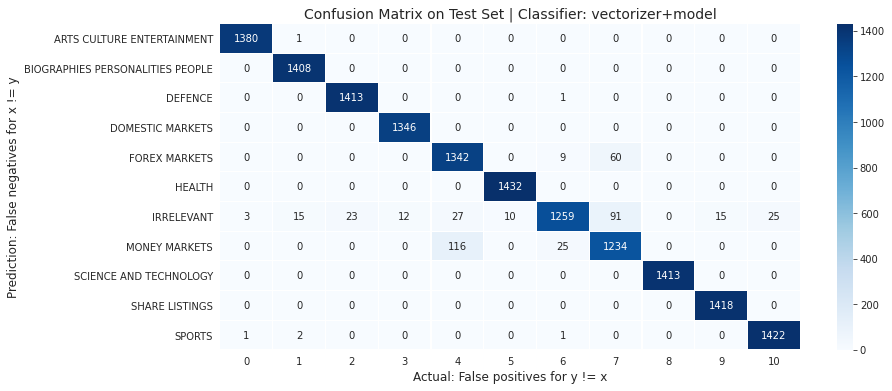

CPU times: user 4min 14s, sys: 1min 11s, total: 5min 26s
Wall time: 5h 35min 58s


In [13]:
%%time
rev_valid_y = le.inverse_transform(valid_y)
encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
for train_name, x_train in train_collection.items():
        clf_logi = get_model(train_name, x_train, train_y)
        for valid_name, x_valid in valid_collection.items():
            if (x_valid.isnull().values.any()):
                continue
            print('----------------------------------------------------------------------')
            print(f'Now, the train_df is {train_name}, the validation_df is {valid_name}')
            df_valid = pd.DataFrame({'key_word':x_valid,'topic':rev_valid_y})
            test_model(df_valid,clf_logi,le,encode_mapping)

## 1.9 Decision Tree Classifier Model

A decision tree is a flowchart-like tree structure where an internal node represents feature(or attribute), the branch represents a decision rule, and each leaf node represents the outcome. The topmost node in a decision tree is known as the root node. It learns to partition on the basis of the attribute value. It partitions the tree in recursively manner call recursive partitioning. This flowchart-like structure helps you in decision making. It's visualization like a flowchart diagram which easily mimics the human level thinking. That is why decision trees are easy to understand and interpret.<br>
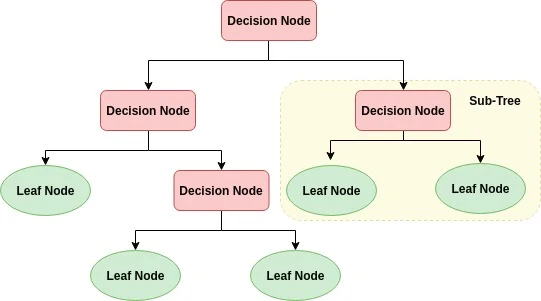

In our design, there are just three models voting in the first layer. Therefore, **Decision Tree Classifier Model** is only used in the second layer, that predicting the actual topics of the data which is predicted as **RELEVANT** in the first layer.

### Functions Used in Decision Tree Classifier

In [2]:
def model_compile(df, x_label, vector_num):

    print(time_stamp()+'Trainning topic', x_label, 'with vector num', vector_num)
    df = preprocess(df, x_label, 'topic')

    label_model = preprocessing.LabelEncoder().fit(df['topic'])
    encode_mapping = dict(zip(label_model.classes_, range(len(label_model.classes_))))

    if vector_num == 1:
        print(time_stamp()+'Smoting word to matrix using TF-IDF...', end=' ')
        x, y = smote_with_vector(df, TfidfVectorizer(), label_model, x_label)
    else:
        print(time_stamp()+'Smoting word to matrix using Count...', end=' ')
        x, y = smote_with_vector(df, CountVectorizer(), label_model, x_label)

    print('Done!')

    new_df = merge_x_y(x, y, x_label, 'topic')
    train_df, test_df = train_test_split(new_df, test_size=0.3)
    
    topic = topic_code.keys()
    train_x = train_df[x_label]
    train_y = train_df['topic']
    test_x = test_df[x_label]
    test_y = test_df['topic']


    # for grid-search
    print(time_stamp()+'Starting Grid-Search with Count...', end=' ')
    count_dt_model, count_dt_accuarcy = grid_search(CountVectorizer(), DecisionTreeClassifier(), train_x, train_y)
    print('Done!')

    print(time_stamp()+'Starting Grid-Search with Tfidf...', end=' ')
    tfidf_dt_model, tfidf_dt_accuarcy = grid_search(TfidfVectorizer(norm=None), DecisionTreeClassifier(), train_x, train_y)
    print('Done!')
    print(time_stamp(), end='')

    if count_dt_accuarcy >= tfidf_dt_accuarcy:
        print(f'*************************************************************')
        print(f'Now the training set is {x_label}, and the model chosen is count')
        print(f'The accuracy is {count_dt_accuarcy}')
        model = count_dt_model
    else:
        print(f'*************************************************************')
        print(f'Now the training set is {x_label}, and the model chosen is tfidf')
        print(f'The accuracy is {tfidf_dt_accuarcy}')
        model = tfidf_dt_model

    # first evaluate the data
    pred_y = model.predict(test_x)
    en_test_y = test_y
    print(time_stamp()+'Total proformance')
    print('F1 score:', metrics.f1_score(en_test_y, pred_y, average='macro'))
    print('Accuarcy:', metrics.accuracy_score(en_test_y, pred_y))
    print('Recall score:', metrics.recall_score(en_test_y, pred_y, average='macro'))
    print('-'*15)
    print('Classification Report:')
    print(classification_report(en_test_y, pred_y))

    # for each topic score
    test_df['topic'] = label_model.inverse_transform(test_df['topic'])
    model_score_no_en(model, label_model, x_label, test_df)

    # for figure
    conf_matrix = confusion_matrix(en_test_y, pred_y)
    fig1 = plt.figure(figsize=(13,6))
    sns.heatmap(conf_matrix,
    #             square=True,
                annot=True, # show numbers in each cell
                fmt='d', # set number format to integer in each cell
                yticklabels=label_model.classes_,
                xticklabels=model.classes_,
                cmap="Blues",
    #             linecolor="k",
                linewidths=.1,
               )
    plt.title(
              f"Confusion Matrix on Test Set | " 
              f"Classifier: {'+'.join([step for step in model.named_steps.keys()])}", 
              fontsize=14)
    plt.xlabel("Actual: False positives for y != x", fontsize=12)
    plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
    plt.show()


def model_evaluate(model, x_label, label_model, df, encode_mapping, vector_num):
    print('Start to evalute', x_label, 'model')
    test_set = preprocess(df, x_label, 'topic')
    test_x = test_set[x_label]
    test_y = test_set['topic']
    topics = list(set(test_set['topic']))

    # evalute total performance
    pred_y = model.predict(test_x)
    en_test_y = label_model.transform(test_y)
    print('Total proformance')
    print('F1 score:', metrics.f1_score(en_test_y, pred_y, average='macro'))
    print('Accuarcy:', metrics.accuracy_score(en_test_y, pred_y))
    print('Recall score:', metrics.recall_score(en_test_y, pred_y, average='macro'))
    print('-'*15)
    print('Classification Report:')
    print(classification_report(en_test_y, pred_y))

    # evalute all the topic performance
    model_report = model_score(model, label_model, x_label, df)

    # save current model and performance
    save_job(model, model_report, vector_num, x_label)

    # for figure
    conf_matrix = confusion_matrix(en_test_y, pred_y)
    fig1 = plt.figure(figsize=(13,6))
    sns.heatmap(conf_matrix,
    #             square=True,
                annot=True, # show numbers in each cell
                fmt='d', # set number format to integer in each cell
                yticklabels=label_model.classes_,
                xticklabels=model.classes_,
                cmap="Blues",
    #             linecolor="k",
                linewidths=.1,
               )
    plt.title(
              f"Confusion Matrix on Test Set | " 
              f"Classifier: {'+'.join([step for step in model.named_steps.keys()])}", 
              fontsize=14)
    plt.xlabel("Actual: False positives for y != x", fontsize=12)
    plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
    plt.show()
    #plt.savefig('model/'+str(vector_num)+'_'+x_label+'.png')


06:58:34 >Trainning topic key_word_100 with vector num 1
06:58:34 >Smoting word to matrix using TF-IDF... Done!
06:59:11 >Starting Grid-Search with Count... Done!
07:17:26 >Starting Grid-Search with Tfidf... Done!
*************************************************************
Now the training set is key_word_100, and the model chosen is count
The accuracy is 0.9352006859463027
07:35:33 >Total proformance
F1 score: 0.9362990403322823
Accuarcy: 0.9378480445497024
Recall score: 0.9371271352095483
---------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1373
           1       0.97      0.99      0.98      1438
           2       0.97      0.98      0.98      1420
           3       0.98      1.00      0.99      1426
           4       0.84      0.88      0.86      1447
           5       0.97      0.99      0.98      1413
           6       0.82      0.72      0.77      1379
           7       0.82      0

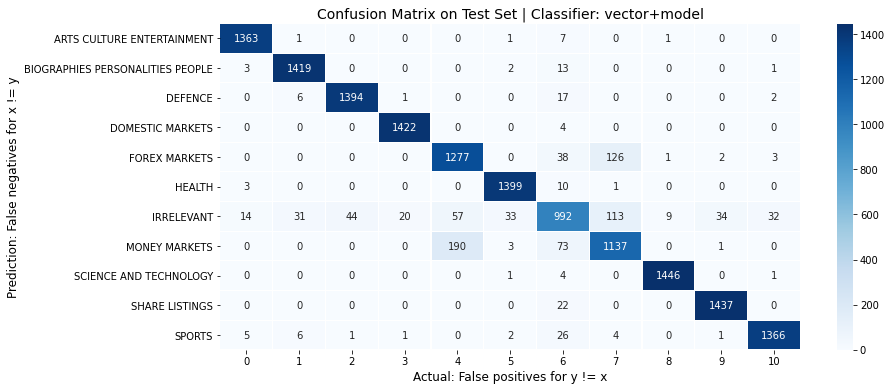

CPU times: user 1min 23s, sys: 2.92 s, total: 1min 26s
Wall time: 37min


In [64]:
%%time
x_label = 'key_word_100'
vector_num = 1

df = pd.read_csv(TRAININGFILE)
model_compile(df, x_label, vector_num)

07:37:16 >Trainning topic article_words with vector num 1
07:37:16 >Smoting word to matrix using TF-IDF... Done!
07:38:09 >Starting Grid-Search with Count... Done!
08:26:56 >Starting Grid-Search with Tfidf... Done!
*************************************************************
Now the training set is article_words, and the model chosen is tfidf
The accuracy is 0.941400651784431
09:16:53 >Total proformance
F1 score: 0.9449398245976807
Accuarcy: 0.9459130768738399
Recall score: 0.9460559240516624
---------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1431
           1       0.97      0.99      0.98      1432
           2       0.96      0.99      0.98      1402
           3       0.98      0.99      0.99      1391
           4       0.86      0.90      0.88      1408
           5       0.97      0.99      0.98      1395
           6       0.87      0.75      0.80      1443
           7       0.85      

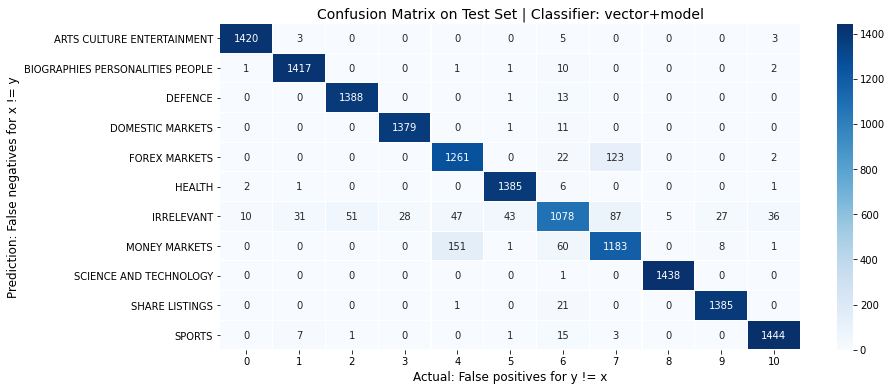

CPU times: user 2min 52s, sys: 7.13 s, total: 2min 59s
Wall time: 1h 39min 39s


In [66]:
%%time
x_label = 'article_words'
vector_num = 1

df = pd.read_csv(TRAININGFILE)
model_compile(df, x_label, vector_num)

10:19:47 >Trainning topic key_word_100 with vector num 2
10:19:47 >Smoting word to matrix using Count... Done!
10:20:22 >Starting Grid-Search with Count... Done!
10:27:36 >Starting Grid-Search with Tfidf... Done!
10:34:48 >*************************************************************
Now the training set is key_word_100, and the model chosen is tfidf
The accuracy is 0.8848865697944344
10:34:49 >Total proformance
F1 score: 0.8886335739414932
Accuarcy: 0.8920821865198746
Recall score: 0.8914597857882804
---------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1488
           1       0.92      0.95      0.94      1438
           2       0.95      0.95      0.95      1434
           3       0.96      0.98      0.97      1370
           4       0.77      0.82      0.79      1415
           5       0.94      0.94      0.94      1400
           6       0.75      0.57      0.65      1409
           7       0.

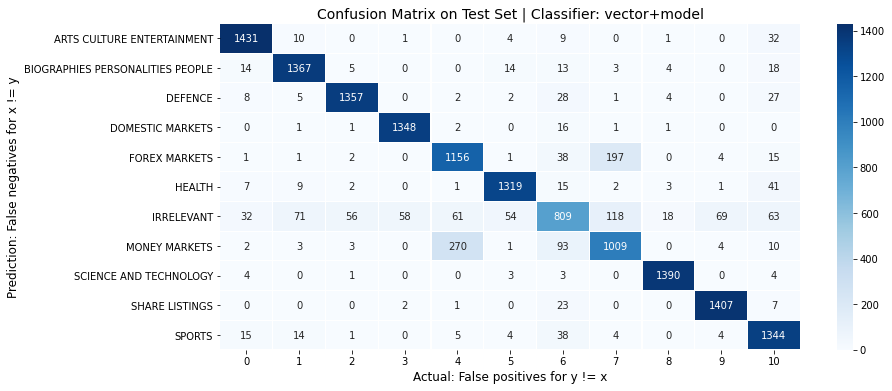

CPU times: user 59 s, sys: 1.17 s, total: 1min
Wall time: 15min 3s


In [72]:
%%time

x_label = 'key_word_100'
vector_num = 2

df = pd.read_csv(TRAININGFILE)
model_compile(df, x_label, vector_num)

09:46:07 >Trainning topic article_words with vector num 2
09:46:07 >Smoting word to matrix using Count... Done!
09:46:46 >Starting Grid-Search with Count... Done!
10:01:56 >Starting Grid-Search with Tfidf... Done!
10:17:08 >*************************************************************
Now the training set is article_words, and the model chosen is tfidf
The accuracy is 0.8846397766084486
10:17:08 >Total proformance
F1 score: 0.8837402002250677
Accuarcy: 0.8854253344428087
Recall score: 0.8855346387623022
---------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1432
           1       0.92      0.94      0.93      1493
           2       0.94      0.95      0.95      1429
           3       0.97      0.98      0.97      1412
           4       0.78      0.82      0.80      1401
           5       0.75      0.97      0.85      1374
           6       0.75      0.60      0.66      1444
           7       

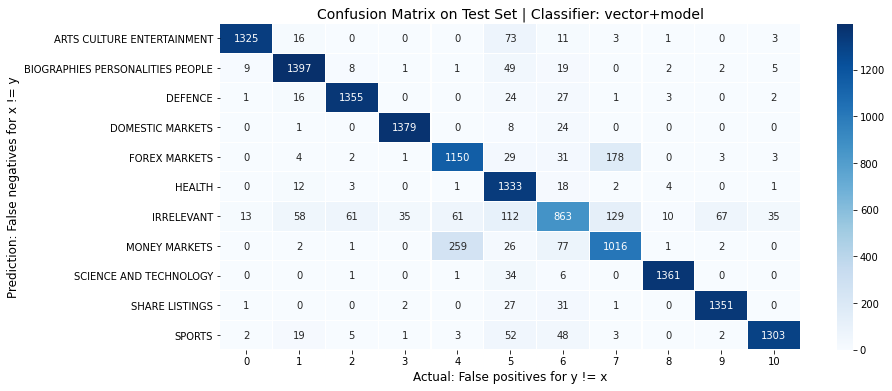

CPU times: user 1min 19s, sys: 2.19 s, total: 1min 21s
Wall time: 31min 2s


In [71]:
%%time

x_label = 'article_words'
vector_num = 2

df = pd.read_csv(TRAININGFILE)
model_compile(df, x_label, vector_num)

## 1.10 Support Vector Classification Model (Support Vector Machine)

The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.<br>
To separate the two classes of data points, there are many possible hyperplanes that could be chosen. Our objective is to find a plane that has the maximum margin, i.e the maximum distance between data points of both classes. Maximizing the margin distance provides some reinforcement so that future data points can be classified with more confidence.<br>
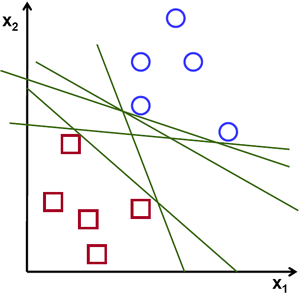


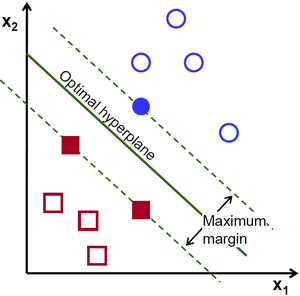

### Functions Defined for Support Vector Machine Model

In [3]:
def test_model_with_vect(df_test,model,le,encode_mapping, my_vect):
    test_x = df_test.key_word
    test_y = df_test.topic
    topics = list(set(df_test['topic']))
    en_test_y = le.transform(test_y)
    y_pred = model.predict(my_vect.transform(test_x))
    get_scores(en_test_y,y_pred,type(model).__name__)
    print(encode_mapping)
    print(f"Classification Report:\n{classification_report(en_test_y, y_pred)}")
    print("The scores for each topic is:")
    scores_for_topics_with_vect(df_test,topics,model,le, my_vect)
    conf_matrix = confusion_matrix(en_test_y, y_pred)
    print(conf_matrix)
    fig1 = plt.figure(figsize=(13,6))
    sns.heatmap(conf_matrix,
    #             square=True,
                annot=True, # show numbers in each cell
                fmt='d', # set number format to integer in each cell
                yticklabels=le.classes_,
                xticklabels=model.classes_,
                cmap="Blues",
    #             linecolor="k",
                linewidths=.1,
               )
    plt.title(
              f"Confusion Matrix on Test Set | ", 
              fontsize=14)
    plt.xlabel("Actual: False positives for y != x", fontsize=12)
    plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
    plt.show()
    
def scores_for_topics_with_vect(df,topics,model,le, my_vect):
    scores = []
    for topic in topics:
        topic_scores_with_vect(df,topic,model,le,scores, my_vect)
    scores.sort(reverse=True,key=lambda x:x[1]['accuracy'])
    for item in scores:
        print(item)

def topic_scores_with_vect(df,topic,model,le,scores, my_vect):
    filtered_df = df[df.topic==topic]
    test_x = filtered_df.key_word.apply(lambda x: x.replace('_', ''))
    test_y = filtered_df.topic
    #le.fit(train_y)
    en_test_y = le.transform(test_y)
    prediction = model.predict(my_vect.transform(test_x))
    scores.append(get_scores(en_test_y,prediction,type(model).__name__,topic))

def get_scores(en_train_y,pred_y,model_name,topic=None):
    f1 = f1_score(en_train_y,pred_y,average='macro')
    accuracy = accuracy_score(en_train_y,pred_y)
    recall = recall_score(en_train_y,pred_y,average='macro')
    if(topic==None):
        print("F1 score for ",model_name," model is ",f1)
        print("Accuracy score for ",model_name," model is ",accuracy)
        print("Recall score for ",model_name," model is ",recall,"\n")
    else:
        return ([topic,{'accuracy':accuracy,'f1':f1,'recall':recall}])

In [13]:
def model_vect_selection(df_train):
    # get train_x and train_y
    new_df = df_train
    new_df = new_df.dropna()
    train_x = new_df.article_words.apply(lambda x: x.replace('_', ''))
    train_y = new_df.topic
    le = preprocessing.LabelEncoder()
    le.fit(train_y)
    encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
    en_train_y = le.transform(train_y)
    topics = list(set(new_df['topic']))
    # Using SMOTE 1 with tfidf  to solve imbalance
    smote = SMOTE(random_state=1)
    vectorizer = TfidfVectorizer()
    vectorizer.fit(train_x)
    train_vectors = vectorizer.transform(train_x)
    smo_x,smo_y_tf = smote.fit_sample(train_vectors,en_train_y)
    new_train_x_tf = vectorizer.inverse_transform(smo_x)
    new_train_x_tf = pd.Series([','.join(item) for item in new_train_x_tf])
    
    # Start grid search
    #count_clf_NB,count_clf_accuracy = grid_search(CountVectorizer(),MultinomialNB(),new_train_x,smo_y,topics)
    #tfidf_clf_NB,tfidf_clf_accuracy = grid_search(TfidfVectorizer(norm=None),MultinomialNB(),new_train_x,smo_y,topics)
    
    #replace the grid search by avg_score as model is already tuning 
    accs_tf_tf = np.mean(cross_val_score(svm.SVC(gamma=0.001, C=10.,decision_function_shape = 'ovo', probability = True), 
                           TfidfVectorizer().fit_transform(new_train_x_tf), smo_y_tf, cv=5))
    
    accs_tf_wc = np.mean(cross_val_score(svm.SVC(gamma=0.001, C=10.,decision_function_shape = 'ovo', probability = True), 
                           CountVectorizer().fit_transform(new_train_x_tf), smo_y_tf, cv=5))
    
    # Using SMOTE2 with word count to solve imbalance
    smote = SMOTE(random_state=1)
    vectorizer = CountVectorizer()
    vectorizer.fit(train_x)
    train_vectors = vectorizer.transform(train_x)
    smo_x,smo_y_wc = smote.fit_sample(train_vectors,en_train_y)
    new_train_x_wc = vectorizer.inverse_transform(smo_x)
    new_train_x_wc = pd.Series([','.join(item) for item in new_train_x_wc])

    
    accs_wc_tf = np.mean(cross_val_score(svm.SVC(gamma=0.001, C=10.,decision_function_shape = 'ovo', probability = True), 
                           TfidfVectorizer().fit_transform(new_train_x_wc), smo_y_wc, cv=5))
    
    accs_wc_wc = np.mean(cross_val_score(svm.SVC(gamma=0.01, C=10.,decision_function_shape = 'ovo', probability = True), 
                           CountVectorizer().fit_transform(new_train_x_wc), smo_y_wc, cv=5))
    
    # get the best model 
    accs_list = [accs_tf_tf, accs_tf_wc, accs_wc_tf, accs_wc_wc]
    print(accs_list)
    return (accs_list) 

### 1.10.1 Pipeline Hyper Parameter

The description of hyper parameter tuning is given below.<br>
- C: Regularization parameter. The strengh of the regularization is inversely proportional to C.
- gamma: Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
- class_weight: Set the parameter C of class i to class_weight[i]*C for SVC.
- decision_function_shape: Whether to return a one-vs-rest ('ovr') decision function of shape as all other classifiers.

### 1.10.2 Two Layer Model Construction

In [1]:
# get the data and vectoerizer 
TRAINING_FILE = "keyword.csv"
TEST_FILE = "key_word_test.csv"
df_train = pd.read_csv(TRAINING_FILE)
df_test = pd.read_csv(TEST_FILE)

junk_train = df_train.rename(columns={ "article_words": "key_word"})
new_df = junk_train
new_df = new_df.dropna()
train_x = new_df.key_word.apply(lambda x: x.replace('_', ''))
the_vect = TfidfVectorizer().fit(train_x)


Grid search to find the optimal svm model parameters


In [2]:
param_grid = {'C': np.geomspace(0.01,100,num=5,endpoint=True), 'gamma' : np.geomspace(0.1,10,num=3,endpoint=True),
              'class_weight': [None,'balanced'], 'decision_function_shape': ['ovo','ovr']}
grid = GridSearchCV(svm.SVC(probability = True), param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(the_vect.transform(train_x), new_df.topic)

In [16]:
print(f"Best parameter: {grid.best_params_}")

Best parameter: {'C': 10.0, 'class_weight': None, 'decision_function_shape': 'ovo', 'gamma': 0.001}


In [1]:
model_vect_selection(new_df)

[0.9246876390155789, 0.9612799786861503, 0.973524698150643, 0.939917588569306]


We get our optimal model: SMOTE by WC and convert X by TFIDF, Now we will get the validation set and see its performance in validation set. 

In [14]:
new_train_x,smo_y,topics,le,encode_mapping = smote_data(df_train,TfidfVectorizer(),'article_words')
new_train_x_100,_,_,_,_ = smote_data(df_train,TfidfVectorizer(),'key_word_100')

In [15]:
train_x,valid_x,train_y,valid_y = train_test_split(new_train_x,smo_y,test_size=0.3,random_state=42)
valid_size = valid_x.shape[0]
train_x_100,valid_x_100,train_y,valid_y = train_test_split(new_train_x_100,smo_y,test_size=0.3,random_state=42)

In [3]:
# get the model 
svm_model = svm.SVC(gamma=0.001, C=10.,decision_function_shape = 'ovo', probability = True).fit(the_vect.transform(train_x), train_y)

----------------------------------------------------------------------
Now,the test_df is valid_x_10
F1 score for  SVC  model is  0.6543227808447133
Accuracy score for  SVC  model is  0.6925954592363261
Recall score for  SVC  model is  0.6947194844114872 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.45      0.58      1381
           1       0.56      0.55      0.56      1408
           2       0.74      0.95      0.83      1414
           3       0.65      0.97      0.78      1346
           4       0.59      0.92      0.72      1411
           5       0.67      0.79      0.72      1432
           6       0.62      0.05      0.09      1480
           7       0.81      0.33      0.47

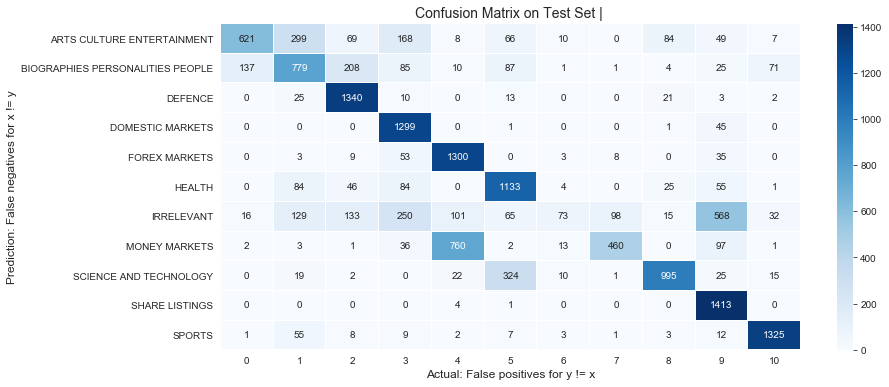

----------------------------------------------------------------------
Now,the test_df is valid_x_20
F1 score for  SVC  model is  0.7144879726569862
Accuracy score for  SVC  model is  0.742453560371517
Recall score for  SVC  model is  0.7443465516991636 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.55      0.64      1381
           1       0.65      0.64      0.65      1408
           2       0.76      0.97      0.85      1414
           3       0.78      0.99      0.87      1346
           4       0.58      0.98      0.73      1411
           5       0.70      0.89      0.78      1432
           6       0.80      0.15      0.25      1480
           7       0.83      0.39      0.53 

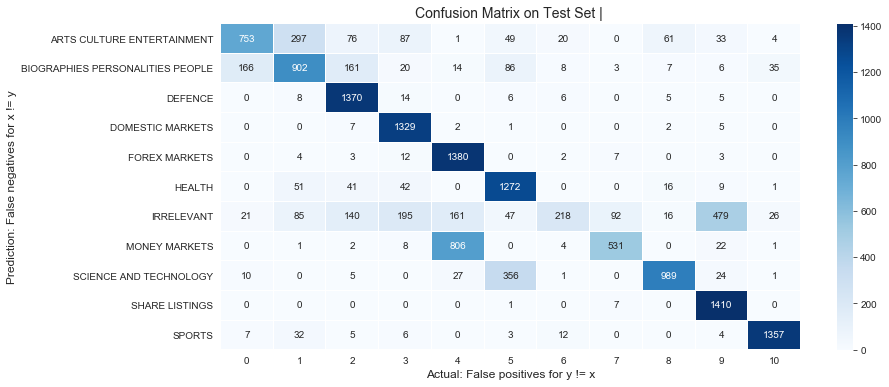

----------------------------------------------------------------------
Now,the test_df is valid_x_50
F1 score for  SVC  model is  0.7794328803240718
Accuracy score for  SVC  model is  0.7940531475748194
Recall score for  SVC  model is  0.7950994787276939 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.53      0.68      1381
           1       0.68      0.82      0.74      1408
           2       0.79      0.98      0.88      1414
           3       0.88      0.99      0.93      1346
           4       0.58      0.97      0.73      1411
           5       0.80      0.90      0.85      1432
           6       0.76      0.34      0.47      1480
           7       0.82      0.43      0.57

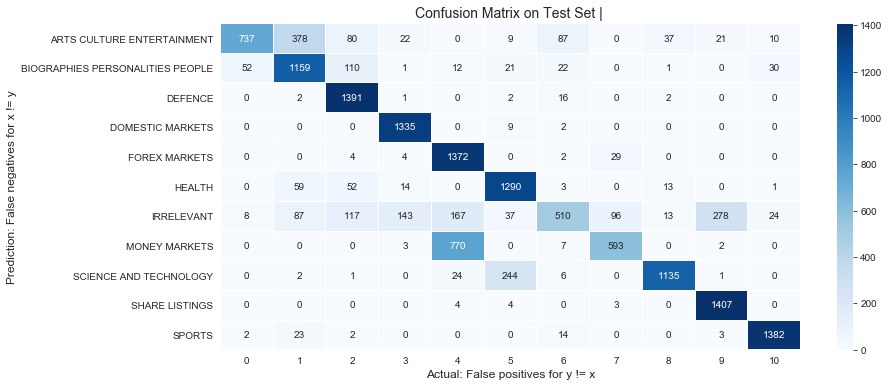

----------------------------------------------------------------------
Now,the test_df is valid_x_100
F1 score for  SVC  model is  0.8304513798090863
Accuracy score for  SVC  model is  0.8364938080495357
Recall score for  SVC  model is  0.8369614198389267 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.70      0.80      1381
           1       0.77      0.85      0.81      1408
           2       0.83      0.98      0.90      1414
           3       0.91      0.99      0.95      1346
           4       0.61      0.94      0.74      1411
           5       0.87      0.93      0.89      1432
           6       0.77      0.54      0.63      1480
           7       0.80      0.46      0.5

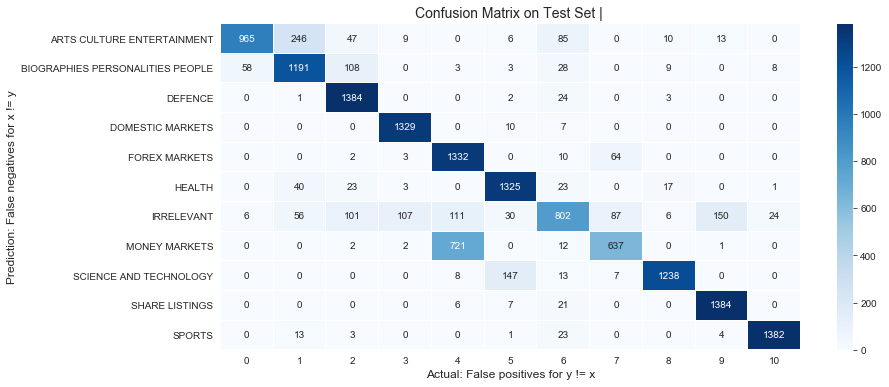

----------------------------------------------------------------------
Now,the test_df is valid_x
F1 score for  SVC  model is  0.8255148713392423
Accuracy score for  SVC  model is  0.8143704850361198
Recall score for  SVC  model is  0.8127076453201831 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.80      0.88      1381
           1       0.91      0.87      0.89      1408
           2       0.98      0.93      0.95      1414
           3       0.97      0.72      0.83      1346
           4       0.65      0.80      0.71      1411
           5       0.88      0.93      0.91      1432
           6       0.42      0.86      0.57      1480
           7       0.88      0.47      0.61   

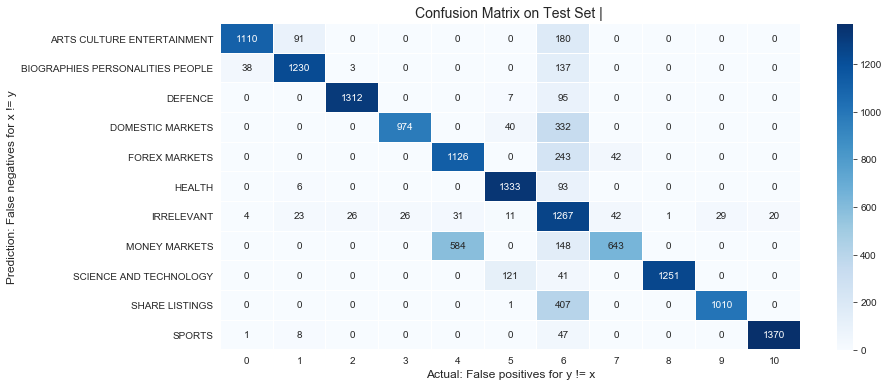

In [24]:
# reverse valid_y
rev_valid_y = le.inverse_transform(valid_y)
valid_set =[valid_x_10,valid_x_20,valid_x_50,valid_x_100,valid_x]

for ele in valid_set:
    print('----------------------------------------------------------------------')
    print(f'Now,the test_df is {namestr(ele)}') 
    df_valid = pd.DataFrame({'key_word':ele,'topic':rev_valid_y})
    test_model_with_vect(df_valid, svm_model,le,encode_mapping, the_vect)

# 2 Ensemble Model Construction

From the results above, it could be seen that no models above are able to predict every topic 100% correctly. However, a glance at the results indicates that different types of model have their strong prediction among different topics. Hence, an idea comes to mind that if we construct an ensemble model to integrate all precise prediction from different models,the final prediction quality could be tremendously enhanced.

<font color='blue'>Ensemble methods</font> are mega-algorithms that <font color='blue'>combine different models</font> into one model and they can:<br>
- Decrease variance
- Decrease bias
- Improve performance
- Aggregation of information in groups (by James Surowiecki, 1907)
<div style="text-align:right">— Week 7 Lecture Slides Part1, 2020.</div>

There are five simple ensemble methods introduced in this course: <br>
&emsp;    1.Majority vote for models' outputs.<br>
&emsp;    2.Weighted averages/votes.<br>
&emsp;    3.Treat the output of each model as a feature and train a model on that.<br>
&emsp;    4.Mixture of experts.<br>
&emsp;    5."Bagging" method.

A 2-level structure is also applied to the ensemble model. In the first step, the models trained to distinguish relevant and irrelevant topics are used, and all relevant articles are sent to the second layer to predict the categories of all relevant articles and their related probabilities.


Considering that in this group project, only an imbalanced training data set and a test set are provided, using "Bagging" method is not practical since we cannot tune the "Bagging" method outputs with a validation data set, and the original size of training data set is merely 9500 lines, which is assumed to be small for "bagging" process. Moreover, among the models: Multinomial Naive Bayes, Support Vector Machine, Logistic Regression, and Decision Tree Classifier, there is no prior knowledge that how much expertise they have on the training data set correspondingly. Thus, we choose the first method for the sakes of easy operation.

## 2.1 Sub-Models Selection

From the test results on validation sets in part 1, we choose the following models to construct the ensemble model.

NOTE: **key_word_x** means only the top $x$ occurence words in the data set show up in each article, namely, it replaces the role of *article_word* feature.

NOTE: Since the models below are generated from pipeline, we do not need to know what exactly the hyper-parameters are. The model constrcution process could be regarded as encapsulated.

### 2.1.1 First Layer Selection

1. **svm_ir_clf**<br>
This SVM model svm.SVC() is trained with "key_word_100" in training set,and is tested with "key_word_100".Its accuracy on training set is 81.24%.<br>
2. **rel_clf_tfidf_NB.joblib**<br>
This Naive Bayes model MultinomialNB() is trained with full training set, and is tested with full test set. Its accuracy on training set is 83.70%.<br>
3. **best_logi** <br>
This Logistic Regression model LogisticRegression() is trained with full training set, and is tested with full test set. Its accuracy on trainig set is 86.5%.


### 2.1.2 Second Layer Selection

1. **tfidf_logi_pipe** <br>
This model does not require text to get pre-processed. This Logistic Regression model is trained with "key_word_50" and tested with "key_word_50". The topics it has high accuracy prediction on are:<br>
<ul>
    <li> ARTS CULTURE ENTERTAINMENT</li>
    <li> DOMESTIC MARKETS</li>
    <li> SPORTS </li>
    <li> SHARE LISTINGS</li>
    <li> FOREX MARKETS </li>
    <li> DEFENCE </li>
</ul>
<br>
2. **clf_NB_1**<br>
This model does not require text to get pre-processed. This Multinomial Naive Bayes model is trained with "artcile_words" and tested with "key_word_50". The topics it has high accuracy prediction on are:<br>
<ul>
    <li> ARTS CULTURE ENTERTAINMENT</li>
    <li> DOMESTIC MARKETS</li>
    <li> SPORTS </li>
    <li> SHARE LISTINGS</li>
    <li> FOREX MARKETS </li>
    <li> DEFENCE </li>
</ul>
<br>
3. **clf_NB_2**<br>
This model does not require text to get pre-processed. This Multinomial Naive Bayes model is trained with "artcile_words" and tested with "key_word_100". The topics it has high accuracy prediction on are:<br>
<ul>
    <li> HEALTH</li>
    <li> DOMESTIC MARKETS</li>
    <li> SPORTS </li>
    <li> SHARE LISTINGS</li>
    <li> MONEY MARKETS </li>
    <li> DEFENCE </li>
</ul>
<br>
4. **clf_NB_3**<br>
This model does not require text to get pre-processed. This Multinomial Naive Bayes model is trained with "key_word_100" and tested with "key_word_50". The topics it has high accuracy prediction on are:<br>
<ul>
    <li>BIOGRAPHIES PERSONALITIES PEOPLE</li>
</ul>
<br>
5. **svm_proba_1**<br>
This model requires text to get pre-processed. This Support Vector Machine model is trained with "key_word_100" and tested with "key_word_100". The topics it has high accuracy prediction on are:<br>
<ul>
    <li> ARTS CULTURE ENTERTAINMENT</li>
    <li> DOMESTIC MARKETS</li>
    <li> SPORTS </li>
    <li> SHARE LISTINGS</li>
    <li> FOREX MARKETS </li>
    <li> DEFENCE </li>
    <li>BIOGRAPHIES PERSONALITIES PEOPLE</li>
</ul>
<br>
6. **svm_proba_2**<br>
This model requires text to get pre-processed. This Support Vector Machine model is trained with "key_word_100" and tested with "article_words". The topics it has high accuracy prediction on are:<br>
<ul>
    <li> DOMESTIC MARKETS</li>
    <li> SPORTS </li>
    <li> FOREX MARKETS </li>
    <li> HEALTH </li>
</ul>
<br>
7. **1_article_words_model**<br>
This model does not require text to get pre-processed. This Decision Tree Classifier model is trained with "article_words" and tested with "article_words". The topics it has high accuracy prediction on are:<br>
<ul>
    <li> SPORTS</li>
</ul>
<br>
8. **2_article_words_model**<br>
This model does not require text to get pre-processed. This Decision Tree Classifier model is trained with "article_words" and tested with "article_words". The topics it has high accuracy prediction on are:<br>
<ul>
    <li> SPORTS</li>
</ul>
<br>

## 2.2 Code Part

NOTE: We save the sub-model configurations in a **json** file called Configuration.json.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scipy
import json
import seaborn as sns
from collections import namedtuple
from sklearn.base import TransformerMixin
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline
import joblib
import matplotlib.pyplot as plt

### Basic Values

In [2]:
model_path = 'Choesn_model/'
configure_file_path = 'Choesn_model/Configuration.json'
TESTFILE = '../test.csv'
boolean = 'True'

### 2.2.1 Model Object
```class Model(object)``` records information of each model to ensemble

In [3]:
class Model(object):

    def  __init__(self, model, name, test_set, topic, is_preprocess, level):
        self.model = model
        self.name = name
        self.test_set = test_set
        self.topic = topic
        self.is_preprocess = is_preprocess
        self.level = level
        self.encoding = None

    # for debug use
    def show(self):
        print(
            self.name,'\t',
            self.test_set,'\t',
            self.topic,'\t',
            self.is_preprocess,'\t',
            self.level
        )

    def predict(self, x):
        if self.level == 1:
            pred_y = self.model.predict(x)
            for i in range(pred_y.shape[0]):
                pred_y[i] = self.convert(str(pred_y[i]))
            
            return pred_y.astype(int)
        else:
            return self.model.predict(x)
        
    def predict_proba(self, x):
        return self.model.predict_proba(x)

    def set_encoding(self, encoding):
        self.encoding = encoding

    def convert(self, x):
        return int(self.encoding[x])

### 2.2.2 Load Model Details from ```.json``` Configuration File
create model objects from ```.json``` file

In [4]:
def load_configuration_to_model(file_path):
    '''
    Load the json file and figure the parameter of each model

    Return: (Tuple Object) with two sub-list
            sub-list_1: Model for layer one (For revelent and irrevelent)
            sub-list_2: Model for layer two (For topic decision)
    '''

    with open(configure_file_path, 'r') as json_fp:
        configuration = json.load(json_fp)

    layer_1 = []
    layer_2 = []
    
    for model_figure in configuration:

        # read the figure
        model_file = joblib.load(model_path + model_figure['model_name'])
        name = model_figure['model_name']
        test_set = model_figure['test_set']
        topic = model_figure['topic']
        is_preprocess = boolean == model_figure['preprocess']
        level = int(model_figure['level'])

        # New model object to save those arguments
        model = Model(model_file, name, test_set, topic, is_preprocess, level)

        # append to model list for futher processing
        if level == 1:
            model.set_encoding(model_figure['encoding'])
            layer_1.append(model)
        elif level == 2:
            layer_2.append(model)

    return layer_1,layer_2

### 2.2.3 Prepare Testing Data and Preprocess Vectors

In [5]:
def get_vector(column_name, special=False):
    '''
    df                      str: The train df
    fit_column              str: The column for vector to fit

    Return: (Vectorizer Object)
            Vectorizer of current column
    '''
    train_df = pd.read_csv(TRAINFILE)
    if special is not False:
        train_df = train_df.dropna()
        train_df[special] = train_df[special].apply(lambda x: x.replace('_', ''))

    # prepare the tranform vector
    vector = TfidfVectorizer().fit(train_df[column_name])

    return vector

def preprocess(df, column_name_list):
    '''
    This function to use to prepare all the data for ensemble system running
    including RAW data and Vector-preprocess data

    Return: (Dict object)
            A after preprocessing data dict, it order by column_name_list
        
            ext:
            Input: column_name_list: ['key_word_100', 'article_words']
            Output: test_data_dict: test_data_dict['key_word_100'] --> key_word_100
                                    test_data_dict['article_words'] -> article_words
                                    test_data_dict['raw']          --> original data
    '''

    test_data_dict = {}

    # first add original data
    test_data_dict['raw'] = df

    vector = get_vector('article_words', special='article_words')
    
    for column in column_name_list:
        en_data = vector.transform(df[column])
        test_data_dict[str(column)] = en_data

    # for special data, add it by manul
    vector = get_vector('key_word_100')
    test_data_dict['key_word_100_1'] = vector.transform(df['key_word_100'])

    return test_data_dict

In [6]:
df = pd.read_csv(TESTFILE)
df = df_keyword_generator(df,df_train)
dict_data = preprocess(df, ['key_word_100', 'article_words'])

### 2.2.4 Ensemble Part

#### 2.2.4.1 Load Lists of Models

In [7]:
model_list_1, model_list_2 = load_configuration_to_model(configure_file_path)

#### 2.2.4.2 Utilisation Function and Values for Ensemble Model

In [8]:
# create a Vote structure include following information:
#    model: which model votes             - int
#    cate:  which category it votes       - int
#    proba: the probability it provides   - float
Vote = namedtuple("Vote", "model cate proba")

In [9]:
topic_list = list(set(df['topic']))
topic_list.sort()

def create_encode(topics):
    encode_list = dict()
    decode_list = dict()

    for num, topic in enumerate(topics):
        decode_list[num] = topic
        encode_list[topic] = num
        
    return encode_list, decode_list

topic_encode, topic_decode = create_encode(topic_list)
sample_size = len(df)

In [10]:
def create_weights(topics):
    topic_count = {}
    for topic in topics:
        topic_count[topic] = 0

    for model in model_list_1 + model_list_2:
        for topic in model.topic:
            topic_count[topic] += 1
    return [topic_count[max(topic_count)]/i for i in topic_count.values()]

weight_list = create_weights(topic_list)

#### 2.2.4.3 Ensemble Core Code

In [11]:
def vote_proba(votes, topic_dict, weights=None):
    cate_count = len(topic_dict)

    column_names = ['predict', 'mean_proba', 'models', 'probas']
    df = pd.DataFrame(columns = column_names)

    for num, sample in enumerate(votes): 
        # vote_list to count vote, init with 11 zeros
        vote_list = [[] for _ in range(cate_count)]
        vote_probas = [[] for _ in range(cate_count)]
        for vote in sample:
            vote_list[vote.cate].append(vote.model)
            vote_probas[vote.cate].append(vote.proba)
        vote_count = [len(cate_list) for cate_list in vote_list]
        vote_proba_mean = [0 for _ in range(cate_count)]
        for i in range(cate_count):
            if len(vote_probas[i]) > 0:
                vote_proba_mean[i] = sum(vote_probas[i])/len(vote_probas[i])
                
        if weights is not None:
            for i in range(len(vote_count)):
                vote_count[i] *= weights[i]
            
        # get category chosen by vote
        max_vote = max(vote_count)
        
        # if no vote, create None column, else, create column by vote.
        if max_vote == 0:
            res = [None, None, None, None]
        else:
            # check count
            # if draw vote, check proba
            if vote_list.count(max_vote) > 1:
                chosen_cate = vote_proba_mean.index(max(vote_proba_mean))

            # if not draw
            else:
                chosen_cate = vote_count.index(max_vote)

            # append to result DataFrame
            res = [topic_dict[chosen_cate], vote_proba_mean[chosen_cate], vote_list[chosen_cate], vote_probas[chosen_cate]]
        new_row = pd.Series(res, index=column_names)
        df = df.append(new_row, ignore_index=True)
        
    return df

In [12]:
def irre_vote(model_list, sample_size):
    all_votes = [[] for _ in range(sample_size)]
    for clf in model_list:
            if clf.is_preprocess is True:
                test_x = dict_data[clf.test_set]
            else:
                test_x = dict_data['raw'][clf.test_set]
            y_pred = clf.predict(test_x)
            y_pred_proba = clf.predict_proba(test_x)
            for i in range(sample_size):
                cate, proba = y_pred[i], y_pred_proba[i]

                clf_name = clf.name.split('.')[0]
                # create namedtuple (model_name, category, category_proba)
                all_votes[i].append(Vote(clf_name, cate, proba.max()))
    topic_dict = {0: 'IRRELEVANT', 1: 'RELEVANT'}
    return vote_proba(all_votes, topic_dict)

In [13]:
def cate_vote(model_list, sample_size, irre_res, truth):
    global weight_list
    
    column_names = ['label', 'predict', 'mean_proba', 'models', 'probas']
    final_df = pd.DataFrame(columns = column_names)
    
    all_votes = [[] for _ in range(sample_size)]
    for clf in model_list:
        if clf.is_preprocess is True:
            test_x = dict_data[clf.test_set]
        else:
            test_x = dict_data['raw'][clf.test_set]
        y_pred = clf.predict(test_x)
        y_pred_proba = clf.predict_proba(test_x)
        for i in range(sample_size):
            cate, proba = y_pred[i], y_pred_proba[i]
            if topic_decode[cate] in clf.topic:
                            
                clf_name = clf.name.split('.')[0]

                all_votes[i].append(Vote(clf_name, cate, proba.max()))
    rela_res = vote_proba(all_votes, topic_decode, weight_list)
    for i in range(sample_size):
        if irre_res['predict'].iloc[i] == 'IRRELEVANT':
            final_res = [truth[i]] + irre_res.iloc[i].tolist()
        else:
            final_res = [truth[i]] + rela_res.iloc[i].tolist()
        new_row = pd.Series(final_res, index=column_names)
        final_df = final_df.append(new_row, ignore_index=True)

    return final_df

In [14]:
res_df = cate_vote(model_list_2, sample_size, irre_vote(model_list_1, sample_size), df['topic'])
res_df = res_df.set_index(df.article_number)

In [15]:
res_df.head(5)

label        predict  mean_proba  \
article_number                                             
9501               IRRELEVANT     IRRELEVANT    0.855460   
9502               IRRELEVANT     IRRELEVANT    0.798582   
9503            FOREX MARKETS  MONEY MARKETS    1.000000   
9504               IRRELEVANT     IRRELEVANT    0.783383   
9505               IRRELEVANT     IRRELEVANT    0.984085   

                                                   models  \
article_number                                              
9501            [svm_ir_clf, rel_clf_tfidf_NB, best_logi]   
9502            [svm_ir_clf, rel_clf_tfidf_NB, best_logi]   
9503                                           [clf_NB_2]   
9504            [svm_ir_clf, rel_clf_tfidf_NB, best_logi]   
9505            [svm_ir_clf, rel_clf_tfidf_NB, best_logi]   

                                                        probas  
article_number                                                  
9501             [0.9415586552948044, 1.0, 0.6248227956728621]  
9502            [0.9294322124011538, 1.0, 0.46631374746266774]  
9503                                      [0.9999999999997726]  
9504             [0.8360490328877616, 1.0, 0.5140987736785823]  
9505             [0.9852943113674895, 1.0, 0.9669618390243637]

### 2.2.5 Evaluation

Classification Report:
                                  precision    recall  f1-score   support

      ARTS CULTURE ENTERTAINMENT       0.43      1.00      0.60         3
BIOGRAPHIES PERSONALITIES PEOPLE       0.64      0.47      0.54        15
                         DEFENCE       0.90      0.69      0.78        13
                DOMESTIC MARKETS       0.50      0.50      0.50         2
                   FOREX MARKETS       0.59      0.79      0.68        48
                          HEALTH       0.67      0.57      0.62        14
                      IRRELEVANT       0.91      0.87      0.89       266
                   MONEY MARKETS       0.64      0.64      0.64        69
          SCIENCE AND TECHNOLOGY       0.00      0.00      0.00         3
                  SHARE LISTINGS       0.56      0.71      0.63         7
                          SPORTS       0.95      0.97      0.96        60

                        accuracy                           0.81       500
             

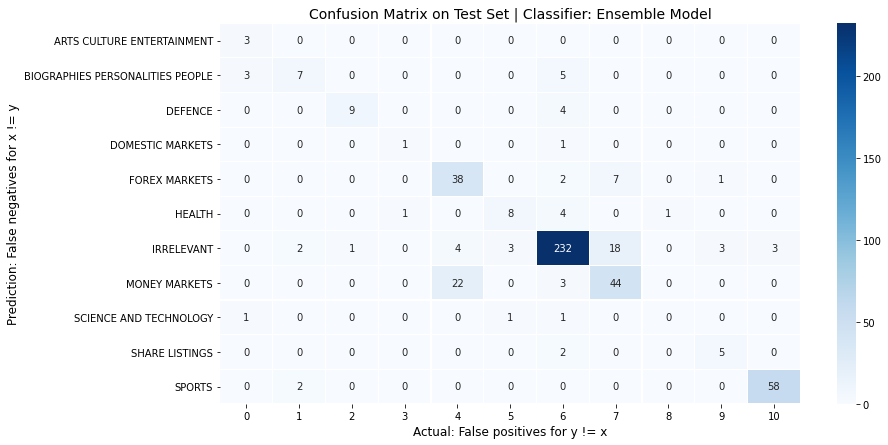

ARTS CULTURE ENTERTAINMENT accuarcy is: 	 1.0
BIOGRAPHIES PERSONALITIES PEOPLE accuarcy is: 	 0.4666666666666667
DEFENCE accuarcy is: 				 0.6923076923076923
DOMESTIC MARKETS accuarcy is: 			 0.5
FOREX MARKETS accuarcy is: 			 0.7916666666666666
HEALTH accuarcy is: 				 0.5714285714285714
IRRELEVANT accuarcy is: 			 0.8721804511278195
MONEY MARKETS accuarcy is: 			 0.6376811594202898
SCIENCE AND TECHNOLOGY accuarcy is: 		 0.0
SHARE LISTINGS accuarcy is: 			 0.7142857142857143
SPORTS accuarcy is: 				 0.9666666666666667


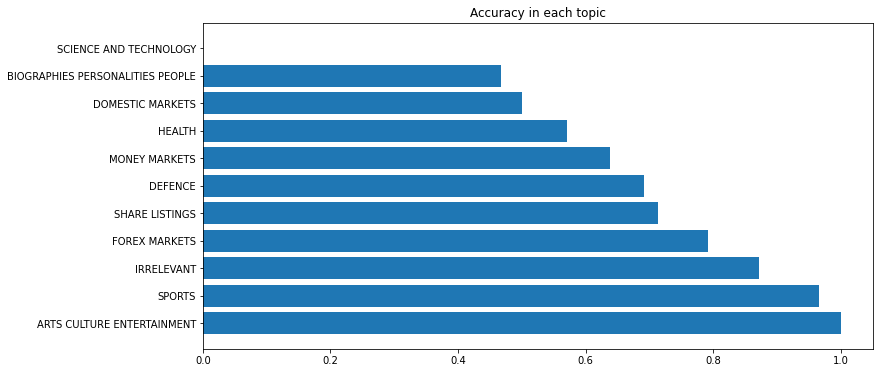

In [16]:
def report(res_df, y_true_label, y_pred_label):
    '''
    Here is for the evaluate the ensamble model

    Input: (DataFrame Object) Should be result of the prediction
    Output: 
    '''
    global topic_list

    test_y = res_df[y_true_label]
    y_pred = res_df[y_pred_label]
    
    print(f"Classification Report:\n{classification_report(test_y, y_pred)}")
    conf_matrix = confusion_matrix(test_y, y_pred)
    print(conf_matrix)
    fig1 = plt.figure(figsize=(13,7))
    sns.heatmap(conf_matrix,
                annot=True, # show numbers in each cell
                fmt='d', # set number format to integer in each cell
                yticklabels=topic_list,
                cmap="Blues",
                linewidths=.1,
               )
    plt.title(
              f"Confusion Matrix on Test Set | " 
              f"Classifier: Ensemble Model", 
              fontsize=14)
    plt.xlabel("Actual: False positives for y != x", fontsize=12)
    plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
    plt.show()

    report = []
    for topic in topic_list:

        # prepare the record
        topic_report = {}
        topic_report['name'] = str(topic)

        # prepare the evaluate data
        test_df = res_df[test_y == topic]

        #evaluate each part
        topic_report['f1_score'] = metrics.f1_score(test_df[y_true_label], test_df[y_pred_label], average='macro')
        topic_report['accuracy'] = metrics.accuracy_score(test_df[y_true_label], test_df[y_pred_label])
        topic_report['recall_score'] = metrics.recall_score(test_df[y_true_label], test_df[y_pred_label], average='macro')
        print(topic,'accuarcy is:', '\t'* (5-(len(topic)+6)//8), topic_report['accuracy'])

        # append t total report for further
        report.append(topic_report)
        

    # sort the report for plt
    report.sort(reverse=True, key=lambda x: x['accuracy'])

    #plt.style.use('ggplot')
    figure = plt.figure(figsize=(12,6))
    #plt.xticks(rotation=90)
    plt.title('Accuracy in each topic')
    plt.barh([i['name'] for i in report], [j['accuracy'] for j in report])

    plt.show()

report(res_df, 'label', 'predict')

### 2.2.6 Recommendation

In [20]:
# recommandation
for topic in topic_list:
    if topic != "IRRELEVANT":
        df_filter = res_df[res_df['predict'] == topic]
        
        print(topic)
        recom_article = df_filter.sort_values(by="mean_proba").head(10).index.tolist()
        recom_article.sort()
        print(recom_article)

ARTS CULTURE ENTERTAINMENT
[9604, 9703, 9789, 9830, 9834, 9933, 9952]
BIOGRAPHIES PERSONALITIES PEOPLE
[9526, 9575, 9582, 9645, 9758, 9811, 9854, 9878, 9940, 9988]
DEFENCE
[9559, 9576, 9607, 9616, 9670, 9721, 9770, 9773, 9842, 9987]
DOMESTIC MARKETS
[9833, 9994]
FOREX MARKETS
[9529, 9531, 9542, 9554, 9564, 9647, 9751, 9892, 9894, 9943]
HEALTH
[9621, 9661, 9807, 9873, 9911, 9926, 9929, 9947, 9978, 9982]
MONEY MARKETS
[9550, 9587, 9599, 9665, 9677, 9753, 9808, 9883, 9916, 9959]
SCIENCE AND TECHNOLOGY
[9617]
SHARE LISTINGS
[9518, 9601, 9655, 9666, 9667, 9668, 9715, 9972, 9999]
SPORTS
[9608, 9695, 9701, 9736, 9757, 9801, 9809, 9818, 9862, 9931]


In [18]:
for topic in topic_list:
    if topic != "IRRELEVANT":
        df_filter = res_df[res_df['predict'] == topic]
        
        print(topic)
        print('\t', end='')
        print('\n\t'.join(df_filter.sort_values(by="mean_proba").head(10).label.values))

ARTS CULTURE ENTERTAINMENT
	ARTS CULTURE ENTERTAINMENT
	ARTS CULTURE ENTERTAINMENT
	SCIENCE AND TECHNOLOGY
	ARTS CULTURE ENTERTAINMENT
	BIOGRAPHIES PERSONALITIES PEOPLE
	BIOGRAPHIES PERSONALITIES PEOPLE
	BIOGRAPHIES PERSONALITIES PEOPLE
BIOGRAPHIES PERSONALITIES PEOPLE
	SPORTS
	BIOGRAPHIES PERSONALITIES PEOPLE
	BIOGRAPHIES PERSONALITIES PEOPLE
	BIOGRAPHIES PERSONALITIES PEOPLE
	BIOGRAPHIES PERSONALITIES PEOPLE
	BIOGRAPHIES PERSONALITIES PEOPLE
	SPORTS
	BIOGRAPHIES PERSONALITIES PEOPLE
	IRRELEVANT
	BIOGRAPHIES PERSONALITIES PEOPLE
DEFENCE
	DEFENCE
	DEFENCE
	DEFENCE
	IRRELEVANT
	DEFENCE
	DEFENCE
	DEFENCE
	DEFENCE
	DEFENCE
	DEFENCE
DOMESTIC MARKETS
	HEALTH
	DOMESTIC MARKETS
FOREX MARKETS
	FOREX MARKETS
	MONEY MARKETS
	FOREX MARKETS
	IRRELEVANT
	IRRELEVANT
	MONEY MARKETS
	MONEY MARKETS
	MONEY MARKETS
	FOREX MARKETS
	FOREX MARKETS
HEALTH
	HEALTH
	HEALTH
	SCIENCE AND TECHNOLOGY
	HEALTH
	HEALTH
	HEALTH
	HEALTH
	IRRELEVANT
	HEALTH
	HEALTH
MONEY MARKETS
	MONEY MARKETS
	MONEY MARKETS
	MONEY MARK

Classification Report:
                                  precision    recall  f1-score   support

      ARTS CULTURE ENTERTAINMENT       0.43      1.00      0.60         3
BIOGRAPHIES PERSONALITIES PEOPLE       0.70      0.70      0.70        10
                         DEFENCE       0.90      1.00      0.95         9
                DOMESTIC MARKETS       0.50      1.00      0.67         1
                   FOREX MARKETS       0.40      0.67      0.50         6
                          HEALTH       0.80      0.80      0.80        10
                      IRRELEVANT       0.00      0.00      0.00        10
                   MONEY MARKETS       0.70      0.64      0.67        11
          SCIENCE AND TECHNOLOGY       0.00      0.00      0.00         2
                  SHARE LISTINGS       0.56      1.00      0.71         5
                          SPORTS       1.00      0.83      0.91        12

                        accuracy                           0.68        79
             

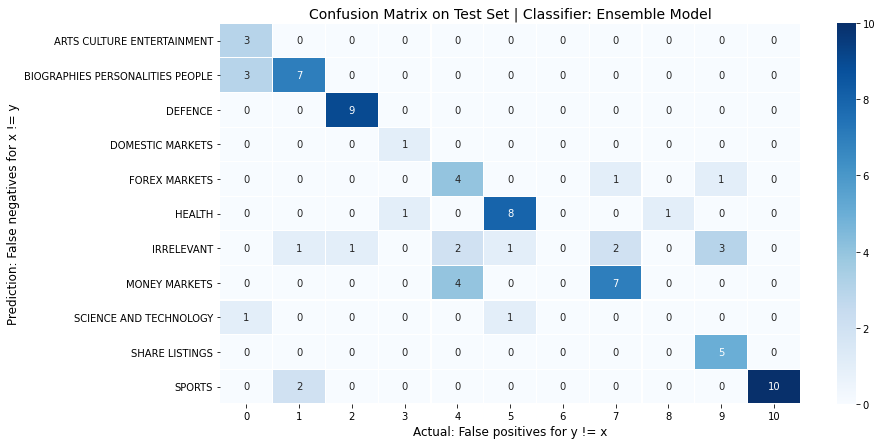

ARTS CULTURE ENTERTAINMENT accuarcy is: 	 1.0
BIOGRAPHIES PERSONALITIES PEOPLE accuarcy is: 	 0.7
DEFENCE accuarcy is: 				 1.0
DOMESTIC MARKETS accuarcy is: 			 1.0
FOREX MARKETS accuarcy is: 			 0.6666666666666666
HEALTH accuarcy is: 				 0.8
IRRELEVANT accuarcy is: 			 0.0
MONEY MARKETS accuarcy is: 			 0.6363636363636364
SCIENCE AND TECHNOLOGY accuarcy is: 		 0.0
SHARE LISTINGS accuarcy is: 			 1.0
SPORTS accuarcy is: 				 0.8333333333333334


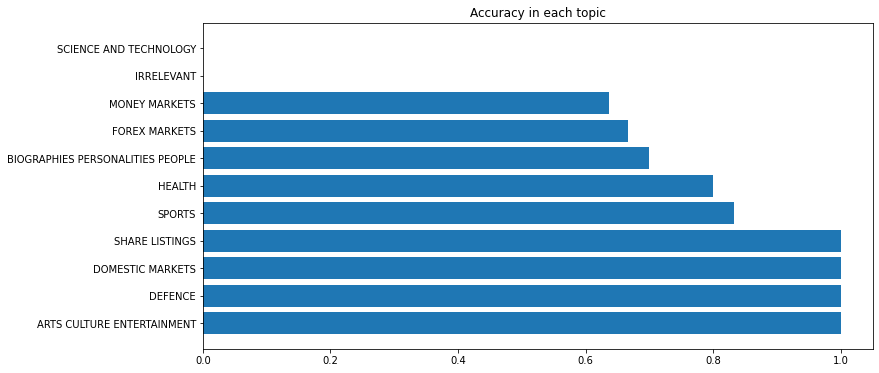

In [19]:
article_list = []
for topic in topic_list: 
    if topic != "IRRELEVANT":
        df_filter = res_df[res_df['predict'] == topic]
        
        article_list += df_filter.sort_values(by="mean_proba").head(10).index.tolist()
article_list.sort()
report(res_df.loc[article_list, :], 'label', 'predict')

### 2.2.7 Analysis of Result

Although the ensemble model does not have good accuracy on some of the topics, from the result of all topics' recommendation, it could be seen that, after sorting each article's votes got and prediction probabilities under each topic, the general output is satisfying.

There is a trade-off between the accuracies of **IRRELEVANT** and some of the relevant topics like **DEFENCE**, **DOMESTIC MARKET**. If we set a threshold for the first layer, namely how many patterns matched the **IRRELEVANT** topic for a single article too low, then, if an article's style is slightly close to **IRRELEVANT**, it would be predicted as **IRRELEVANT**. This will lead to some relevant articles would be classified as **IRRELEVANT** and cannot go to the second layer for further prediction. The result of this would be losing many articles which are not **IRRELEVANT** in the first layer. At the end, there will be few articles recommended to users.

Among all topics, **SPORTS**, **DEFENCE**, and **HEALTH** have an ideal performance on the final recommendation part.

There are only three **ARTS CULTURE ENTERTAINMENT** articles in the test data set. And in our setting, up to 10 articles would be recommended to users. This results in some **BIOGRAPHIES PERSONALITIES PEOPLE** articles, which are similar to the pattern of **ARTS CULTURE ENTERTAINMENT**, get recommended to the **ARTS CULTURE ENTERTAINMENT** reader.

Similarly, as there are just two **DOMESTIC MARKETS** articles in the test set, the low cardinality cannot help us to analyze the performance on this topic.

As for **SCIENCE AND TECHNOLOGY**, there are only three articles in the test set. Because of its low cardinality, and none of the sub-models can have an accurate prediction on this topic, NO **SCIENCE AND TECHNOLOGY** topics are correctly classified. In order to solve this issue, **Boosting** algorithm could help in this case, since in iteration, **SCIENCE AND TECHNOLOGY** articles in the training set will be given higher weight to let the next learner focus on these errors.

A glance at the **MONEY MARKET** recommendation shows that there are four **FOREX MARKET** articles mistakenly classified as **MONEY MARKET**. The reason for this is that **MONEY MARKET** and **FOREX MARKET** are similar topics, that they share many common non-stop words. Increasing the size of training set or applying specific feature engineering on these two topics could help improving the final prediction accuracy.

Furthermore, for **SHARE LISTINGS**, since we cannot control what is the word constitution of an **IRRELEVANT** article, some **IRRELEVANT** articles are wrongly predicted as **SHARE LISTINGS**.

The accuracy of **BIOGRAPHIES PERSONALITIES PEOPLE** is what we expected, a comparatively low number (64%) as we discuss in *Part 1.1.3* that, **BIOGRAPHIES PERSONALITIES PEOPLE**'s top key words' occurence are not distinguishing from the ones of other topics. Thus, it is assumed that this topic would be confused with other similar topics in prediction.

In general, the acceptable outputs among topics are:
<ul>
    <li>HEALTH 8/10 correct</li>
    <li>ARTS CULTURE ENTERTAINMENT true positive =100%</li>
    <li>MONEY MARKETS 8/10 correct</li>
    <li>SPORTS 10/10 correct</li>
    <li>DEFENCE 9/10 correct</li>
    <li>BIOGRAPHIES PERSONALITIES PEOPLE 7/10 correct</li>
    <li> DOMESTIC MARKETS 1/2 correct</li>
</ul>
<br>
The unacceptable outputs among topics are:
<ul>
    <li>SCIENCE AND TECHNOLOGY 0/3 correct</li>
    <li>FOREX MARKET 4/10 correct</li>
    <li>SHARE LISTINGS 5/10 correct</li>
</ul>

# 3. Development Discussion

## 3.1 Practical Improvement on Ensemble Model

### 3.1.1 Three Data Sets Given

In this group project, an imbalanced training data set and a test data set are given. Generally speaking, it is no proper to have a look in the test set except knowing how big the test set is. During the process of this project, we find that applying "train_test_split" on SMOTE applied training data to get the validation set is not effective for tuning. The reason is that SMOTE algorithm duplicates instances in the original training data, and the validation set would be highly similar to the training set. This makes our tuning process not effective.

Also, we have considered applying "train_test_split" before using SMOTE. However, the disadvantage of this practice is that as the original training data set is highly imbalanced, if split, it is possible that only few articles of a particular topic are involved in the training set, which, leads to the prediction on this topic extremely poor.

Hence, if an extra validation data set is given, the process of validation can bring more enhancement to the model tuning. Undoubtedly, a comparatively big validation set is preferred.

### 3.1.2 Boost Algorithm

It could be noticed that for some topics, the misclassification problems are severe, and our algorithm doe not have any designs to solve this. If Boost algorithm is applied in our model, that it could give more weights to the misclassified instances in each iteration, the misclassification is believed to be ameliorated.

## 3.2 Neural Network

Apart from the modules provided in the **sklearn** package, Yinong Wang conducted some researches on **Neural Network**. However, facing the unsatisfactory results from the **Neural Network** output in the initial stage, Yinong decided to design the **ensemble model** in the final stage instead of continuing spending a considerable amount of time on researching **Neural Network**.

Nevertheless, for future development on the text classification in this group project, **Neural Network** could be a practical solution.<br> Yinong's work is given below.

In [2]:
from pandas.api.types import CategoricalDtype
import tensorflow as tf
import time
from tensorflow import one_hot
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2

In [3]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    sp = tf.SparseTensor(indices, coo.data, coo.shape)
    sp = tf.sparse.reorder(sp)
    return sp

In [9]:
train_x = df_train.article_words
train_y = df_train.topic
test_x = df_test.article_words
test_y = df_test.topic

en_train_y = preprocessing.LabelEncoder().fit_transform(train_y)
en_test_y = preprocessing.LabelEncoder().fit_transform(test_y)
categories_list=list(set(train_df['topic']))
print(categories_list)

['ARTS CULTURE ENTERTAINMENT', 'MONEY MARKETS', 'IRRELEVANT', 'BIOGRAPHIES PERSONALITIES PEOPLE', 'SPORTS', 'SHARE LISTINGS', 'HEALTH', 'DEFENCE', 'DOMESTIC MARKETS', 'SCIENCE AND TECHNOLOGY', 'FOREX MARKETS']


In [0]:
# get Count vectors
vectorizer = CountVectorizer().fit(train_x)
train_count_csr = vectorizer.transform(train_x)
test_count_csr = vectorizer.transform(test_x)

# change count vectors from scipy.sparse.csr.csr_matrix to tf.sparse.SparseTensor
train_count_st = convert_sparse_matrix_to_sparse_tensor(train_count_csr)
test_count_st = convert_sparse_matrix_to_sparse_tensor(test_count_csr)

# change count vectors from tf.sparse.SparseTensor to tf.Tensor
train_count_dense = tf.sparse.to_dense(train_count_st)
test_count_dense = tf.sparse.to_dense(test_count_st)

# get Tfid vectors
vectorizer = TfidfVectorizer().fit(train_x)
train_tfid_csr = vectorizer.transform(train_x)
test_tfid_csr = vectorizer.transform(test_x)

# change Tfid vectors from scipy.sparse.csr.csr_matrix to tf.sparse.SparseTensor
train_tfid_st = convert_sparse_matrix_to_sparse_tensor(train_tfid_csr)
test_tfid_st = convert_sparse_matrix_to_sparse_tensor(test_tfid_csr)

# change Tfid vecotors from tf.sparse.SparseTensor to tf.Tensor
train_tfid_dense = tf.sparse.to_dense(train_tfid_st)
test_tfid_dense = tf.sparse.to_dense(test_tfid_st)

# # get Tfid vector vocab size
# vocab_size_tfid = train_vectors.shape[1]
# print(train_vectors.shape,test_vectors.shape)

## 3.1Preprocessing data and preserve order

From ```Tokenizer``` to ```pad_sequences```

In [0]:
word_num = 500
tokenizer = Tokenizer(num_words=word_num)
tokenizer.fit_on_texts(train_x)
train_token = tokenizer.texts_to_sequences(train_x)
test_token = tokenizer.texts_to_sequences(test_x)
train_pad = pad_sequences(train_token)
word_length = train_pad.shape[1]
test_pad = pad_sequences(test_token, maxlen=word_length)

In [0]:
def cate_accuracies(matrix, categories):
    for i_row in range(len(matrix)):
        acc = matrix[i_row][i_row]/sum(matrix[i_row])
        print(f"The accuracy for {categories[i_row]} is {acc}.")

## 3.2Training Model

### Best Training model so far
Already tried:
* other linear layers combinations 
    * with/without dropout layers
    * with/without weight decay
* tokenize + embedding + LSTM
    * extremely slow and inaccurate, not sure if it is because of underfitting or context information not preserved since it is too slow


In [36]:
def network():
    model = Sequential()
    model.add(Dense(128, activation='relu',
              kernel_regularizer=l2(0.01),
              bias_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu',
              kernel_regularizer=l2(0.01),
              bias_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(11, activation='relu',
              kernel_regularizer=l2(0.01),
              bias_regularizer=l2(0.01)))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


estimator = KerasClassifier(build_fn=network, epochs=10, batch_size=20, verbose=0)

start_time = time.time()
estimator.fit(train_count_st, train_y)
print(f"Training time {time.time()-start_time:.0f}s")
train_pred = estimator.predict(train_count_st)
print("Training confusion matrix")
print(metrics.confusion_matrix(train_y, train_pred, categories_list))

train_f1 = metrics.f1_score(train_y, train_pred, average='macro')
print(f"Training f1 score is {train_f1}.")

train_acc = metrics.accuracy_score(train_y, train_pred)
print(f"Training accuracy score is {train_acc}.")

train_recall = metrics.recall_score(train_y, train_pred, average="macro")
print(f"Training recall score is {train_recall}")

test_pred = estimator.predict(test_count_st)
print("Test confusion matrix")

confusion = metrics.confusion_matrix(test_y, test_pred, categories_list)
print(confusion)

test_f1 = metrics.f1_score(test_y, test_pred, average='macro')
print(f"Test f1 score is {test_f1}.")

test_acc = metrics.accuracy_score(test_y, test_pred)
print(f"Test accuracy score is {test_acc}.")

test_recall = metrics.recall_score(test_y, test_pred, average="macro")
print(f"Test recall score is {test_recall}")

test_report = metrics.classification_report(test_y, test_pred)
print(test_report)

cate_accuracies(confusion, categories_list)

Training time 14s
Training confusion matrix
[[   4    0   43   69    1    0    0    0    0    0    0]
 [   0 1594   78    0    0    0    0    0    0    0    1]
 [   1  279 4331   14   48   16   15   22    8    0    0]
 [   0    0   67   93    3    0    2    2    0    0    0]
 [   0    1    9    4 1088    0    0    0    0    0    0]
 [   0    0  103    0    1  114    0    0    0    0    0]
 [   0    0   82    2    1    0   97    1    0    0    0]
 [   0    0   72    0    0    0    1  185    0    0    0]
 [   0    0   91    0    0    0    0    0   42    0    0]
 [   0    1   23    0    1    0   20    0    0   25    0]
 [   0  800   43    0    0    0    0    0    0    0    2]]
Training f1 score is 0.5674625596731576.
Training accuracy score is 0.7973684210526316.
Training recall score is 0.5355785957701877
Test confusion matrix
[[  0   0   2   1   0   0   0   0   0   0   0]
 [  0  63   6   0   0   0   0   0   0   0   0]
 [  0  21 238   1   3   2   1   0   0   0   0]
 [  0   0   9   6   0 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
